Compare the risks of ``used_cars`` dataset

In [3]:
from matplotlib import pyplot as plt
from random import random

def compare_used_cars(dataset_name, location='../experiment_output_exhaustive/', max_risk=1, repeat=1, col=10, 
            max_length=30, title=None):
    test_risks={}
    train_risks={}
    and_counts={}
    aucs={}
    file_numbers={}
    desc=dataset_name
    max_risk=get_max_risk(dataset_name)
    print(max_risk)
    objs = ['gpe','orth']
    for obj in objs:
        algos = ['fc'] if obj=='orth' else ['boosting'] if obj=='gpe' else ['keep']
        for algo in algos:
            methods = ['Newton-CG'] if algo=='fc' else ['']
            for method in methods:
                done = True
                fc_train=[0]*10
                fc_test=[0]*10
                ands = [0]*10
                file_number=0
                for i in range(repeat):
                    filename = dataset_name + '_' + obj + '_' + algo + '_' + method + '_realkd_col_' + \
                        str(col) + '_rep' + str(1) + '.txt'
                    try:
                        f = open(location+'/'+dataset_name+'/'+filename, 'r')
                        file_number+=1
                    except:
                        print(obj, algo, method,'does not exist: ')
                        print(location+'/'+dataset_name+'/'+filename)
                        continue
                    j=-1
                    for line in f:
                        if 'iteration ' in line:
                            j+=1
                        if j>=10:
                            break
                        words=line.split(' ')
                        if 'fc train risk' in line:
                            fc_train[j] += float(words[-1])
                        elif 'fc test risk' in line:
                            fc_test[j] += float(words[-1])
                        if 'if' in line:
                            ands[j]+=line.count('=')+1
                if done:
                    file_numbers[obj + '_' + algo + '_' + method] = file_number
                    train_risks[obj + '_' + algo + '_' + method]=fc_train
                    test_risks[obj + '_' + algo + '_' + method]=fc_test
                    and_counts[obj + '_' + algo + '_' + method]=ands
                    if file_number==0:
                        continue
                    print(obj + '_' + algo + '_' + method+': avg train risk:',sum(fc_train)/10/max_risk/file_number, 
                          'avg test risk', sum(fc_test)/10/max_risk/file_number, '&s:', sum(ands)/10/file_number)

    rg=list(range(1,11))
    plt.figure(figsize=(7.5,5.5))
    colours = {}
    line_width = {}
    width = [1,1, 1, 1]*4
    i = 0
    colors=['green','red','gold','deepskyblue','violet','cyan','brown','deepskyblue','purple', 'lime',
            'slategray','magenta','pink','olive','khaki']
    label_map={'gpe_boosting_':'GB / XGBoost', 'gpe_fc_Newton-CG': 'Gradient Fully-corrective Boosting', 
               'orth_fc_Newton-CG': 'FCOGB', 'xgb_keep_': 'XGBoost', 
              'xgb_fc_Newton-CG': 'XG Fully-corrective Boosting'}
    for item in train_risks:
        color = colors[i]
        colours[item] = color
        line_width[item] = width[i]
        i+=1
        if file_numbers[item]==0:
            continue
        train_risks[item] = [risk / max_risk/file_numbers[item] for risk in train_risks[item]]
        test_risks[item] = [risk / max_risk/file_numbers[item] for risk in test_risks[item]]
        and_counts[item] = [ands / file_numbers[item] for ands in and_counts[item]]
        aucs[item] = and_counts[item][0]+sum((train_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                                   min(max_length, and_counts[item][m]))
                                for m in range(len(train_risks[item])-1))
        print(item, 'auc:', aucs[item])
        print(and_counts[item], train_risks[item])
        plt.step([0]+and_counts[item], [1]+train_risks[item], '--', color=colours[item],
                 linewidth=line_width[item],where='post')
        plt.step([0]+and_counts[item], [1]+test_risks[item], color=colours[item],
                 label=label_map[item]+ '',linewidth=line_width[item],where='post')
    plt.xlabel('Cognitive Complexity', fontsize=12)
    plt.xlim(0,30)
    plt.ylabel('Risk', fontsize=12)
    plt.yscale('log')
    boosting_rule='''Gradient Boosting:
 +17933.38 if PS>=120 & year>=2005
 +7090.75  if km<=125000 & year>=2011
 - 8206.32  if 120<=PS<=160 & year>=2005
 +2401.70  if True
 - 4397.03  if 120<=PS<=220 & 2005<=year<=2011
 +4585.17  if count<=69 & km>=50000 & PS>=160 
              & year<=2005'''
    orth_rule = '''Proposed algorithm:
 +7303.87  if year>=2005
 +6138.81  if count<=149 & PS>=160
 +10100.84 if PS>=120 & year>=2011
 +5744.60  if PS>=220 & year>=2000'''
    plt.annotate('', xy=(21.2, 0.080), xytext=(22, 0.26), fontsize=12, arrowprops=dict(facecolor='black', width=0.2, shrink=0.05))
    plt.annotate('', xy=(11, 0.09), xytext=(4.7, 0.071), fontsize=12,arrowprops=dict(facecolor='black', width=0.2, shrink=0.05))
    
    plt.ylim(0.025, 1.35)
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    plt.text(7.8,0.25, boosting_rule, bbox=bbox_props, fontsize=11)
    plt.text(1,0.031, orth_rule, bbox=bbox_props, fontsize=11)
    plt.grid(visible=True, which='major')
    plt.grid(visible=True, which='minor')
    plt.gca().set_ylim(bottom=0)
    plt.legend()
    plt.savefig('used_cars_compare.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    
    return train_risks, test_risks, and_counts, aucs

def get_max_risk(dataset_name):
    d = {'gdp': 43.986571428571416,
        'wage': 2029057842.6515312,
        'titanic': 1.0,
        'insurance': 322646873.58870494,
        'used_cars': 194464336.77843493,
        'tic_tac_toe': 1.0,
        'boston': 592.1469169960473,
        'world_happiness_indicator': 30.46778212179487,
        'Demographics': 31.64835409252669,
        'IBM_HR': 1.0, 'telco_churn': 1.0,
        'mobile_prices': 3.5,
        'GenderRecognition': 1.0,
        'breast_cancer': 1.0,
        'load_diabetes': 29074.481900452487,
        'iris': 1.0,
        'load_wine': 1.0,
         'suicide_rates_cleaned': 523.7783290690134,
         'videogamesales': 2.70680865164444,
         'digits5': 1.0,
         'red_wine_quality': 32.41651031894934, 
         'banknote': 1.0, 
         'liver': 1.0, 
         'magic': 1.0, 
         'adult': 1.0,
         'who_life_expectancy': 4882.764241803283,
         'vaccine': 228506505.50612897, 
         'ships': 12.342277392898044, 
         'smoking': 7.500299349437478, 
         'covid_vic': 51.62076805721374, 
         'covid_world': 14143.401514056353, 
         'covid': 1082.8170359400497, 
         'bicycle': 1076.416963882381, 
         'austin-water': 3975.767978495398,
         'make_friedman2': 379683.4049960418, 
         'make_friedman3': 1.8780821278399789, 
         'make_friedman1': 226.89125115757616
        }
    if dataset_name in d:
        return d[dataset_name]
    else:
        return 1

1
194464336.77843493
gpe_boosting_: avg train risk: 0.11487454540713478 avg test risk 0.12722486528807636 &s: 19.7
orth_fc_Newton-CG: avg train risk: 0.10029036859594534 avg test risk 0.11924908580687092 &s: 15.9
gpe_boosting_ auc: 6.457178249636495
[3.0, 6.0, 10.0, 11.0, 16.0, 21.0, 25.0, 30.0, 35.0, 40.0] [0.2645509110573421, 0.2022870824853723, 0.14187958375417029, 0.11221783977219958, 0.0916455280655313, 0.08210179754828802, 0.07295471467740056, 0.0644309787818688, 0.06023299339480931, 0.056444024534365776]
orth_fc_Newton-CG auc: 4.939863596764699
[2.0, 5.0, 8.0, 11.0, 15.0, 17.0, 20.0, 24.0, 27.0, 30.0] [0.30332439036990055, 0.1618711977941554, 0.10198183908872074, 0.08398049183450944, 0.0736811325954079, 0.06703474590169989, 0.060176481642162445, 0.05434522178694212, 0.05006708428097964, 0.0464411006649755]


<ipython-input-32-34dbbc10f67f>:115: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.gca().set_ylim(bottom=0)


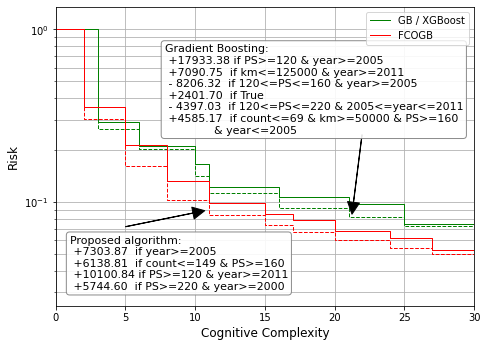

In [34]:
datasets = ['used_cars']

values = ['gpe_boosting_', 
               'orth_fc_Newton-CG']
print(len(datasets))
cols = [10, 10, 10, 5, 10, 3, 10, 4, 10, 10, 10,
       2, 20, 10, 5, 4, 10, 10, 10, 10, 10, 
       10, 10, 10, 10]
max_components = [30] * len(datasets)
f = open("../experiment_output_exhaustive/compare_used_cars.csv", 'w')
f.write('dataset'+(','+','.join(values))*4+'\n')
for i in range(len(datasets)):
        max_risk = get_max_risk(datasets[i])
        train, test, ands, aucs = compare_used_cars(datasets[i], col=cols[i], max_length=max_components[i])
        f.write(datasets[i] + ',')
        for value in values:
            f.write(str(sum(train[value]))+',')
        for value in values:
            f.write(str(sum(test[value]))+',')
        for value in values:
            f.write(str(max(ands[value]))+',')
        for value in values:
            f.write(str(aucs[value])+',')
        f.write('\n')


Compare risks of gradient sum (mwg), gradient boosting (gpe), XGBoost (xgb) and FCOGB (orth)

In [4]:
from matplotlib import pyplot as plt
from random import random

def compare_risks(dataset_name, location='../experiment_output_', max_risk=1, repeat=5, col=10, 
            max_length=30, title=None):
    test_risks={}
    train_risks={}
    and_counts={}
    aucs_test={}
    aucs_train={}
    file_numbers={}
    desc=dataset_name
    max_risk=get_max_risk(dataset_name)
    print(max_risk)
    objs = ['mwg','gpe','xgb','orth']
    for obj in objs:
        algos = ['fc'] if obj=='orth' else ['boosting'] if obj in ['gpe', 'mwg'] else ['keep']
        search = 'exhaustive' if obj in ['xgb', 'orth'] else 'greedy'
        for algo in algos:
            methods = ['Newton-CG'] if algo=='fc' else ['']
            for method in methods:
                done = True
                fc_train=[0]*9
                fc_test=[0]*9
                ands = [0]*9
                file_number=0
                for i in range(repeat):
                    filename = dataset_name + '_' + obj + '_' + algo + '_' + method + '_realkd_col_' + \
                        str(col) + '_rep' + str(i) + '.txt'
                    try:
                        f = open(location+search+''+'/'+dataset_name+'/'+filename, 'r')
                        file_number+=1
                    except:
                        print(obj, algo, method,'does not exist: ')
                        print(location+'/'+dataset_name+'/'+filename)
                        continue
                    j=-1
                    for line in f:
                        if 'iteration ' in line:
                            j+=1
                        if j>=9:
                            break
                        words=line.split(' ')
                        if 'fc train risk' in line:
                            fc_train[j] += float(words[-1])
                        elif 'fc test risk' in line:
                            fc_test[j] += float(words[-1])
                        if 'if' in line and '=' in line:
                            ands[j]+=line.count('=')+1
                if done:
                    file_numbers[obj + '_' + algo + '_' + method] = file_number
                    train_risks[obj + '_' + algo + '_' + method]=fc_train
                    test_risks[obj + '_' + algo + '_' + method]=fc_test
                    and_counts[obj + '_' + algo + '_' + method]=ands
                    if file_number==0:
                        continue
                    print(obj + '_' + algo + '_' + method+': avg train risk:',sum(fc_train)/10/max_risk/file_number, 
                          'avg test risk', sum(fc_test)/10/max_risk/file_number, '&s:', sum(ands)/10/file_number)

    rg=list(range(1,11))
    plt.figure(figsize=(8,6))
    colours = {}
    line_width = {}
    width = [1,1, 1, 1]*4
    i = 0
    colors=['blue','green','red','gold','deepskyblue','violet','cyan','brown','deepskyblue','purple', 'lime',
            'slategray','magenta','pink','olive','khaki']
    label_map={'gpe_boosting_':'Gradient Boosting', 'gpe_fc_Newton-CG': 'Gradient Fully-corrective Boosting', 
               'orth_fc_Newton-CG': 'Orthogonal Fully-corrective Boosting', 'xgb_keep_': 'XGBoost', 
              'xgb_fc_Newton-CG': 'XG Fully-corrective Boosting',
              'mwg_boosting_': 'Gradient Descent'}
    for item in train_risks:
        color = colors[i]
        colours[item] = color
        line_width[item] = width[i]
        i+=1
        if file_numbers[item]==0:
            continue
        train_risks[item] = [risk / max_risk/file_numbers[item] for risk in train_risks[item]]
        test_risks[item] = [risk / max_risk/file_numbers[item] for risk in test_risks[item]]
        and_counts[item] = [ands / file_numbers[item] for ands in and_counts[item]]
        aucs_test[item] = and_counts[item][0]+sum((test_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                 min(max_length, and_counts[item][m]))
                                for m in range(0,len(test_risks[item])-1))
        aucs_train[item] = and_counts[item][0]+sum((train_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                 min(max_length, and_counts[item][m]))
                                for m in range(0,len(train_risks[item])-1))
        
        
        if and_counts[item][-1]<max_length:
            aucs_test[item]+=test_risks[item][-1]*(max_length-and_counts[item][-1])
            aucs_train[item]+=train_risks[item][-1]*(max_length-and_counts[item][-1])
        aucs_train[item] /= max_length
        aucs_test[item] /= max_length # min(max_length, and_counts[item][-1])
        print(item, 'auc:', aucs_train[item], aucs_test[item])
        print(and_counts[item], train_risks[item])
        plt.step([0]+and_counts[item], [1]+train_risks[item], '--', color=colours[item],
                 label=label_map[item],linewidth=line_width[item],where='post')
#         plt.step([0]+and_counts[item], [1]+test_risks[item], color=colours[item],
#                  label=label_map[item],linewidth=line_width[item],where='post')
    plt.title(dataset_name if title is None else title + " risks")
    plt.xlabel('number of rules')
    plt.xlim(0,max_length)
    plt.ylabel('risk')
#     plt.yscale('log')
    plt.grid(visible=True, which='major')
    plt.grid(visible=True, which='minor')
    plt.gca().set_ylim(bottom=0)
    plt.legend()
    plt.show()
    
    return train_risks, test_risks, and_counts, aucs_train, aucs_test

Calculating largest gaps between two algorithms

In [5]:
def map_size_risk(train_risks, sizes):
    risks = [1]
    szs = [0]
    sz = 0
    for i in range(len(sizes)):
        while sz<=sizes[i]:
            sz+=0.2
            szs.append(sz)
            if i==0:
                risk=1
            else:
                risk=train_risks[i-1]
            risks.append(risk)
            
    return risks, szs
def largest_gaps(train_risks, and_counts, a, b, max_size=150):
    risks_a, szs_a = map_size_risk(train_risks[a], and_counts[a])
    risks_b, szs_b = map_size_risk(train_risks[b], and_counts[b])
    max_risk_index_ab = -1000
    max_difference = -1000
    for i in range(min([len(szs_a), len(szs_b), max_size])):
        if risks_a[i]!=1 or risks_b[i]!=1:
            if risks_a[i]-risks_b[i]>max_difference:
                max_risk_index_ab=i
                max_difference = risks_a[i]-risks_b[i]
    return max_difference, szs_a[max_risk_index_ab], risks_a[max_risk_index_ab], risks_b[max_risk_index_ab]

34
1.0
orth_fc_Newton-CG: avg train risk: 0.6058041704610974 avg test risk 0.6713575476408363 &s: 17.94
orth_fc_Newton-CG auc: 0.711042838499621 0.7634821233087133
[2.0, 4.8, 9.0, 14.0, 18.8, 24.0, 29.8, 36.2, 40.8] [0.7563832583774934, 0.7446781967869229, 0.7153053838973085, 0.6779886775430476, 0.6541860608750171, 0.6425192308090478, 0.6325598904541755, 0.6256903253949957, 0.6087306804729641]


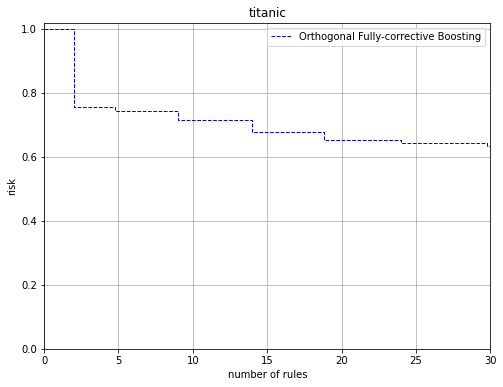

1
orth_fc_Newton-CG: avg train risk: 0.7335305019432093 avg test risk 0.7719243658733073 &s: 13.8
orth_fc_Newton-CG auc: 0.8330740470737209 0.8740477977221108
[2.0, 3.6, 6.8, 10.4, 13.6, 18.4, 23.2, 27.8, 32.2] [0.8606824489197396, 0.8606822400582896, 0.8469538699179833, 0.8379747833483335, 0.8218610719354682, 0.8041024027023278, 0.7957560030322652, 0.7569503614201235, 0.7503418380975619]


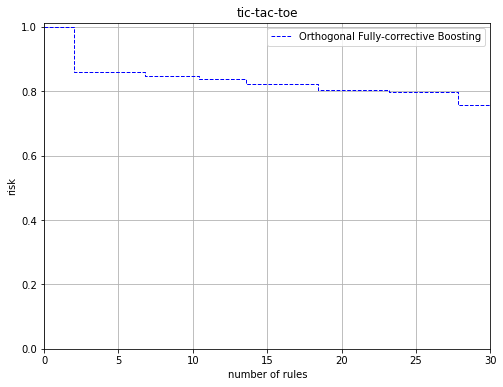

1.0
orth_fc_Newton-CG: avg train risk: 0.2085287768483159 avg test risk 0.4586306789403845 &s: 17.04
orth_fc_Newton-CG auc: 0.3151561124740363 0.549512605030389
[2.0, 5.6, 8.6, 13.0, 18.4, 24.2, 28.6, 32.8, 37.2] [0.7723560421183912, 0.40235082498875235, 0.26732935907868216, 0.18049923874736187, 0.12832374598785434, 0.10151132498601978, 0.08948322984187576, 0.07659226373731193, 0.06684173899690915]


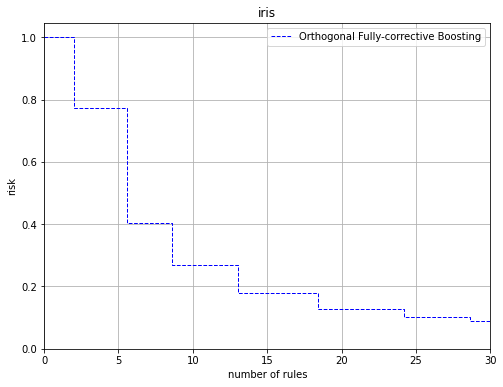

1.0
orth_fc_Newton-CG: avg train risk: 0.2644659373411661 avg test risk 0.24293615221680573 &s: 17.46
orth_fc_Newton-CG auc: 0.381110184735998 0.34874069664104673
[2.0, 7.6, 10.4, 15.4, 18.8, 23.4, 28.0, 32.2, 36.8] [0.5837924450570858, 0.32029422517734163, 0.3086275530549954, 0.2807366524860628, 0.2583386261840176, 0.24400682968784712, 0.22940626926276733, 0.21601359798265332, 0.2034431745188896]


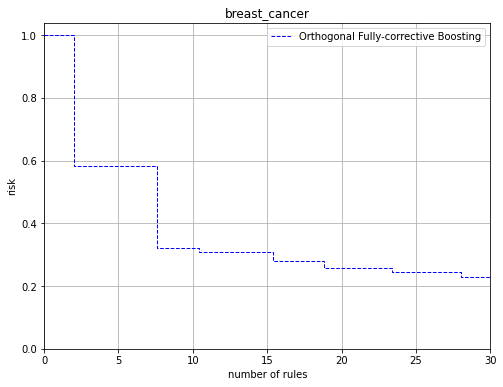

1.0
orth_fc_Newton-CG: avg train risk: 0.132708747984409 avg test risk 0.28949324236145163 &s: 18.68
orth_fc_Newton-CG auc: 0.24072109032573621 0.36812824651444653
[2.0, 5.8, 10.2, 15.6, 21.2, 25.8, 30.8, 35.4, 40.0] [0.6742932705032747, 0.23363153115241939, 0.13240030334884678, 0.08240046062743282, 0.05849914394888082, 0.04424744405398752, 0.036439046699163924, 0.03505416057815764, 0.03012211893192605]


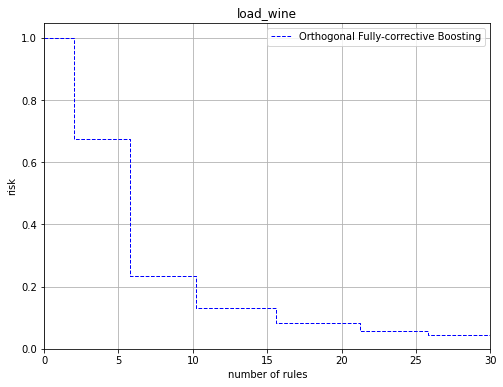

1.0
orth_fc_Newton-CG: avg train risk: 0.5229215754500809 avg test risk 0.5460820956622954 &s: 8.379999999999999
orth_fc_Newton-CG auc: 0.5945033027806477 0.6201633180707001
[2.0, 2.0, 4.0, 6.4, 8.4, 11.6, 13.8, 16.2, 19.4] [0.6319768398176187, 0.6319765823461827, 0.5965805581781236, 0.5789479959603381, 0.5696196218758145, 0.5619553174833696, 0.5568296312608945, 0.5524471103574358, 0.5488820972210313]


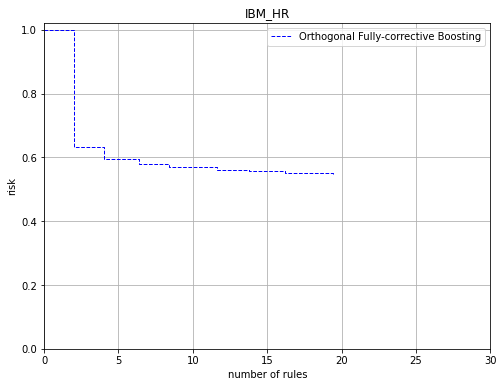

1.0
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/telco_churn/telco_churn_orth_fc_Newton-CG_realkd_col_4_rep1.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/telco_churn/telco_churn_orth_fc_Newton-CG_realkd_col_4_rep2.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/telco_churn/telco_churn_orth_fc_Newton-CG_realkd_col_4_rep3.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/telco_churn/telco_churn_orth_fc_Newton-CG_realkd_col_4_rep4.txt
orth_fc_Newton-CG: avg train risk: 0.6800170687892798 avg test risk 0.6725313487377628 &s: 15.6
orth_fc_Newton-CG auc: 0.7714097630884496 0.7621613182625938
[2.0, 4.0, 6.0, 10.0, 14.0, 20.0, 27.0, 34.0, 39.0] [0.8339725830008635, 0.8339725688550352, 0.7706802621839413, 0.7590783282621685, 0.7467944669404057, 0.7223225944795183, 0.716781088052729, 0.7096904161027244, 0.7068783800154127]


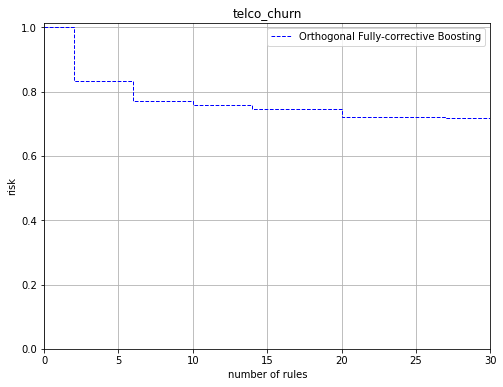

1.0
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/GenderRecognition/GenderRecognition_orth_fc_Newton-CG_realkd_col_3_rep1.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/GenderRecognition/GenderRecognition_orth_fc_Newton-CG_realkd_col_3_rep2.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/GenderRecognition/GenderRecognition_orth_fc_Newton-CG_realkd_col_3_rep3.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/GenderRecognition/GenderRecognition_orth_fc_Newton-CG_realkd_col_3_rep4.txt
orth_fc_Newton-CG: avg train risk: 0.8979021292778577 avg test risk 0.9004424626914338 &s: 7.2
orth_fc_Newton-CG auc: 0.9973489255541972 1.0004564212033265
[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0] [0.9998202498176991, 0.9979656026312673, 0.9978969665474099, 0.9975775686541979, 0.9975494279459878, 0.9972369716989582, 0.9972092888618214, 0.9968964515321718, 0.9968687650890634]


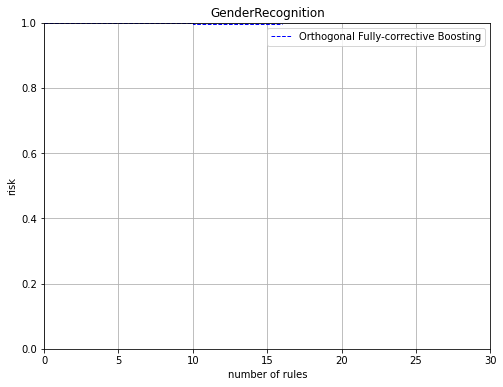

1.0
orth_fc_Newton-CG: avg train risk: 0.35213710373484436 avg test risk 0.3875570203825239 &s: 14.3
orth_fc_Newton-CG auc: 0.44389850666609476 0.4805003554665458
[2.2, 3.8, 7.4, 11.4, 15.2, 19.2, 23.4, 28.2, 32.2] [0.5922623974813328, 0.5922586519618306, 0.47653532862861675, 0.43039266402149534, 0.3505737499410365, 0.30790053521925387, 0.27727303531077363, 0.2606572010984689, 0.23351747368563508]


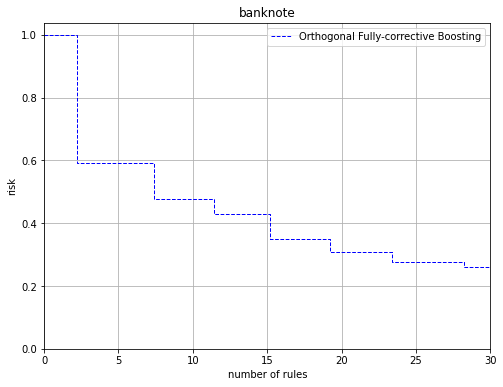

1.0
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/liver/liver_orth_fc_Newton-CG_realkd_col_10_rep2.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/liver/liver_orth_fc_Newton-CG_realkd_col_10_rep3.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/liver/liver_orth_fc_Newton-CG_realkd_col_10_rep4.txt
orth_fc_Newton-CG: avg train risk: 0.8354400706407388 avg test risk 0.8412349793644512 &s: 13.75
orth_fc_Newton-CG auc: 0.9337992997953461 0.938746522630865
[2.0, 2.0, 5.5, 9.0, 14.5, 18.5, 24.5, 28.5, 33.0] [0.9867361693266885, 0.9867339957301874, 0.9544607573329448, 0.9370190165745084, 0.9311104678509584, 0.908048813579345, 0.891978661538025, 0.8836955786317469, 0.8746172458429818]


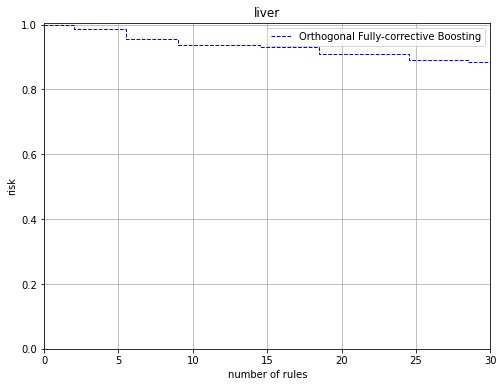

1.0
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/magic/magic_orth_fc_Newton-CG_realkd_col_5_rep1.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/magic/magic_orth_fc_Newton-CG_realkd_col_5_rep2.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/magic/magic_orth_fc_Newton-CG_realkd_col_5_rep3.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/magic/magic_orth_fc_Newton-CG_realkd_col_5_rep4.txt
orth_fc_Newton-CG: avg train risk: 0.7339382344526323 avg test risk 0.7243924092775371 &s: 7.2
orth_fc_Newton-CG auc: 0.8095011951438911 0.7982857184137925
[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0] [0.9352015636542638, 0.8005225999520921, 0.8005225977883992, 0.8005225973776524, 0.8005225972341041, 0.8005225971656678, 0.8005225971443769, 0.8005225971044267, 0.8005225971053405]


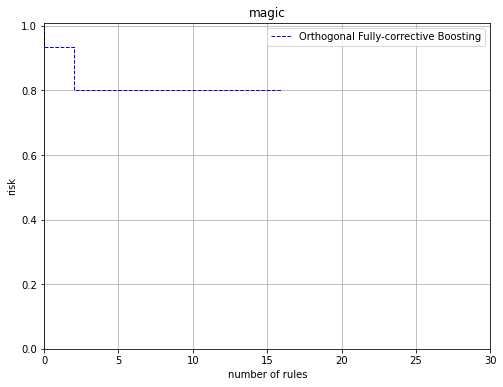

1.0
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/adult/adult_orth_fc_Newton-CG_realkd_col_5_rep1.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/adult/adult_orth_fc_Newton-CG_realkd_col_5_rep2.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/adult/adult_orth_fc_Newton-CG_realkd_col_5_rep3.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/adult/adult_orth_fc_Newton-CG_realkd_col_5_rep4.txt
orth_fc_Newton-CG: avg train risk: 0.5842229296649665 avg test risk 0.5901656737580043 &s: 13.6
orth_fc_Newton-CG auc: 0.6494872664987735 0.6558741932261819
[0.0, 3.0, 6.0, 10.0, 14.0, 19.0, 23.0, 28.0, 33.0] [0.8096813244991145, 0.7381306723207154, 0.6755024808620712, 0.6299714372191613, 0.6069419058854789, 0.6008826386757076, 0.5977641710673661, 0.5961126963558675, 0.587241969764182]


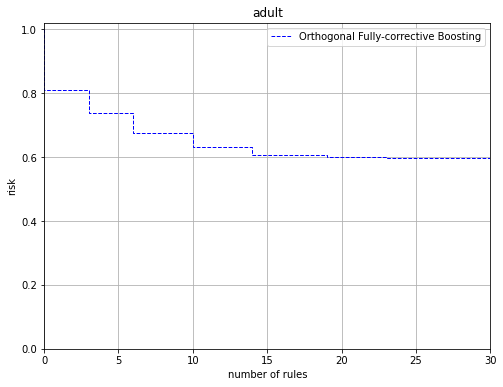

1.0
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/digits5/digits5_orth_fc_Newton-CG_realkd_col_3_rep1.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/digits5/digits5_orth_fc_Newton-CG_realkd_col_3_rep2.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/digits5/digits5_orth_fc_Newton-CG_realkd_col_3_rep3.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/digits5/digits5_orth_fc_Newton-CG_realkd_col_3_rep4.txt
orth_fc_Newton-CG: avg train risk: 0.34816887723710066 avg test risk 0.33090099573611365 &s: 12.2
orth_fc_Newton-CG auc: 0.4230144621929081 0.406425910004128
[2.0, 4.0, 7.0, 10.0, 13.0, 16.0, 20.0, 23.0, 27.0] [0.46604849246524194, 0.4660484853534117, 0.40520375612370774, 0.37912497625747515, 0.3601072563564669, 0.3601083290583963, 0.35130920776972846, 0.35130771208107264, 0.3424305569055049]


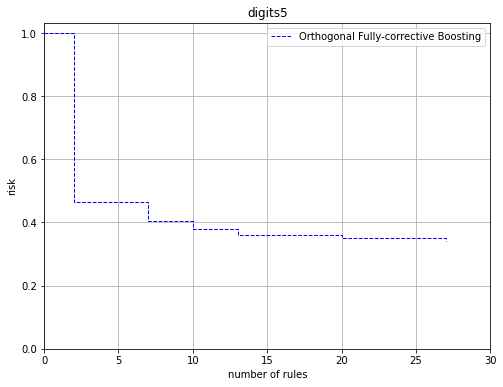

322646873.58870494
orth_fc_Newton-CG: avg train risk: 0.07951924561141557 avg test risk 0.07712150424043902 &s: 17.48
orth_fc_Newton-CG auc: 0.18185629990380736 0.17774893809216358
[3.0, 6.0, 9.0, 13.0, 16.4, 24.2, 29.6, 34.4, 39.2] [0.15840808420092123, 0.10613716510214284, 0.08696392574806527, 0.08179099509151139, 0.07741148385311089, 0.07470922041013402, 0.0721719965815999, 0.06982166387144516, 0.06777792125522508]


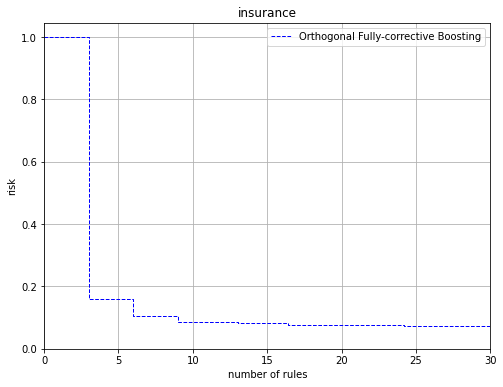

226.89125115757616
orth_fc_Newton-CG: avg train risk: 0.045438632342120505 avg test risk 0.05185181141333058 &s: 17.96
orth_fc_Newton-CG auc: 0.18326297344576445 0.18756520437339
[3.4, 6.6, 9.8, 13.4, 18.0, 23.2, 29.0, 35.0, 41.2] [0.08227333938524446, 0.06249555845124567, 0.053192330844143466, 0.04739357493401795, 0.044510676248360935, 0.04297528380025979, 0.04162266079902205, 0.04050165394491977, 0.039421245013990955]


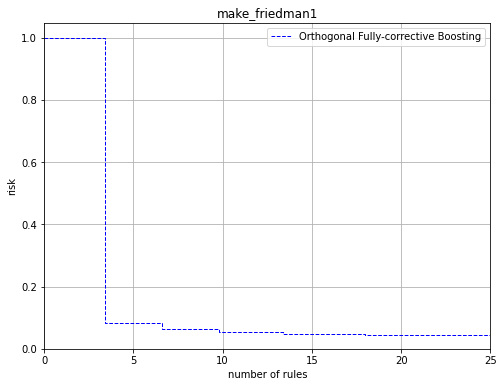

379683.4049960418
orth_fc_Newton-CG: avg train risk: 0.06272702618283733 avg test risk 0.0634192306164344 &s: 13.02
orth_fc_Newton-CG auc: 0.22187281088254518 0.22234671942496714
[3.0, 5.4, 8.4, 11.6, 14.6, 16.8, 19.8, 23.6, 27.0] [0.1932950643233557, 0.10927073958656544, 0.08192859633158747, 0.052825885514920755, 0.04437156791701912, 0.04003941483836952, 0.0367549288838032, 0.03585391305182914, 0.03293015138092286]


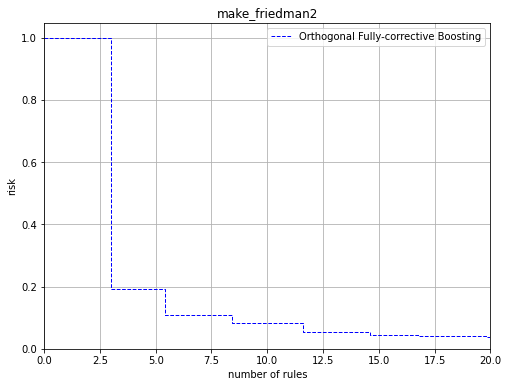

1.8780821278399789
orth_fc_Newton-CG: avg train risk: 0.019109967168435753 avg test risk 0.022033833341341357 &s: 17.52
orth_fc_Newton-CG auc: 0.1528017669073717 0.1553213440340645
[4.0, 7.6, 11.0, 14.6, 19.0, 23.4, 27.4, 31.8, 36.4] [0.03381021541861172, 0.027015571019386196, 0.022614378641743045, 0.020225083084201026, 0.018919175206552338, 0.01794397130023874, 0.017331117483727485, 0.016826000855494808, 0.016414158674402192]


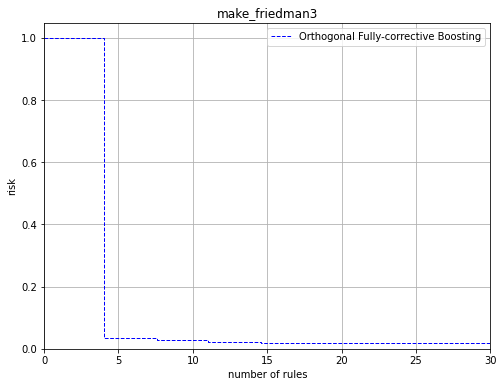

2029057842.6515312
orth_fc_Newton-CG: avg train risk: 0.28147038017230586 avg test risk 0.33626911820540806 &s: 21.419999999999998
orth_fc_Newton-CG auc: 0.45035821214489663 0.4934346968826145
[5.4, 9.2, 13.2, 19.2, 23.4, 27.6, 33.4, 38.8, 44.0] [0.38777122569827766, 0.3506753724350897, 0.3275594152438476, 0.31193375389009803, 0.29992337880998704, 0.29139907006235155, 0.2859313403565124, 0.2817083359387033, 0.2778019092881915]


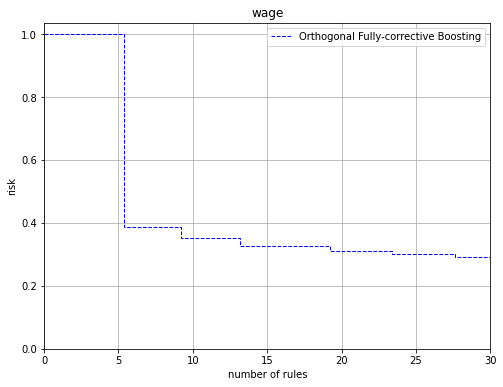

31.64835409252669
orth_fc_Newton-CG: avg train risk: 0.1767915731545731 avg test risk 0.17960913626644942 &s: 11.0
orth_fc_Newton-CG auc: 0.24904219351540194 0.25214384594457717
[2.0, 4.0, 6.0, 8.8, 12.4, 14.6, 17.4, 20.4, 24.4] [0.20866226506646207, 0.19994798507212633, 0.19721781193538773, 0.19631964905802876, 0.19459256243374007, 0.1936561046729777, 0.19287043961214428, 0.19243829425584263, 0.1922106194390219]


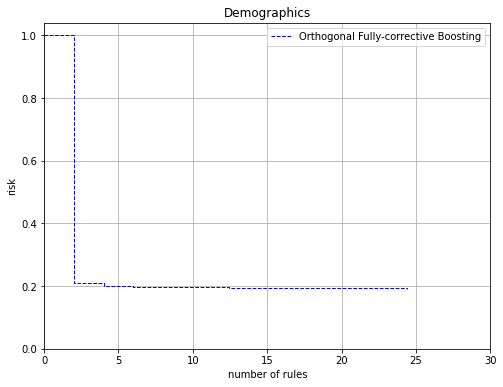

43.986571428571416
orth_fc_Newton-CG: avg train risk: 0.003227662374791306 avg test risk 0.004141695985072835 &s: 11.08
orth_fc_Newton-CG auc: 0.0699624372338309 0.07097186516096651
[2.0, 4.4, 7.0, 9.6, 12.0, 14.6, 17.4, 20.4, 23.4] [0.00459289059462489, 0.003882397289800848, 0.0036283658547839825, 0.0034819053265194725, 0.0033966736888121837, 0.0033470074458253687, 0.0033225833139011443, 0.003313550359645625, 0.0033112498739995486]


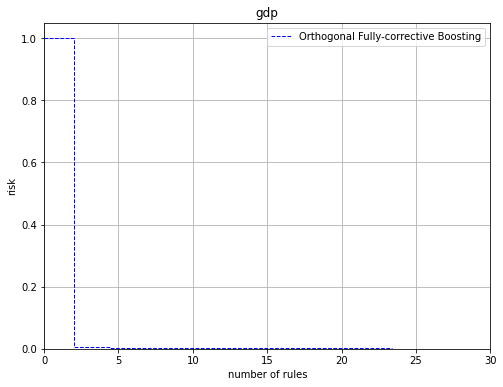

194464336.77843493
orth_fc_Newton-CG: avg train risk: 0.07139044163307981 avg test risk 0.07783901827150237 &s: 15.48
orth_fc_Newton-CG auc: 0.17634891706469988 0.1827652265624352
[3.0, 6.0, 10.0, 14.6, 17.6, 20.8, 24.0, 27.4, 31.4] [0.1836437885179059, 0.11552557307946669, 0.0862986969078632, 0.06988613391599222, 0.061862906201735304, 0.05598393945651035, 0.05078058476676543, 0.04655290470456786, 0.04336988877999096]


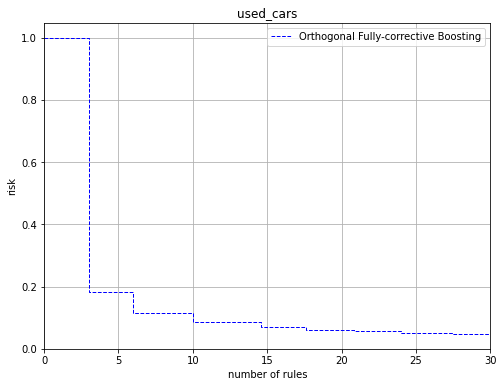

29074.481900452487
orth_fc_Newton-CG: avg train risk: 0.10102834096234192 avg test risk 0.12294479048712374 &s: 21.32
orth_fc_Newton-CG auc: 0.2302714872613835 0.2402807370779738
[3.8, 6.8, 11.8, 16.2, 23.0, 29.2, 34.4, 40.8, 47.2] [0.15996789561045544, 0.12395838562614103, 0.1160334038100855, 0.11072023434912318, 0.10683440154044035, 0.10328892873786208, 0.09964163050592566, 0.09644248260635413, 0.09339604683703198]


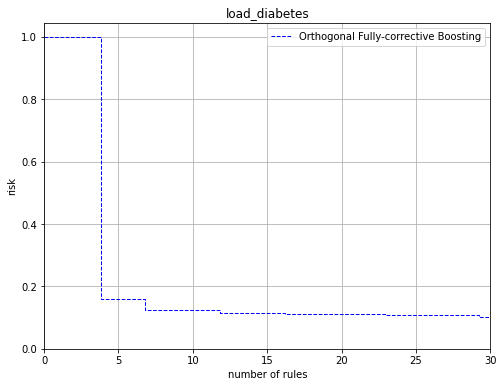

592.1469169960473
orth_fc_Newton-CG: avg train risk: 0.05167194130659897 avg test risk 0.05250167501032112 &s: 20.119999999999997
orth_fc_Newton-CG auc: 0.16247740982380274 0.1591449001822968
[3.2, 8.2, 12.2, 17.6, 22.0, 27.2, 32.4, 36.4, 42.0] [0.08186512622455273, 0.06914911437900617, 0.05999899440917102, 0.0553754720272715, 0.053235049934575576, 0.05140403560213639, 0.04992082620216377, 0.04854661363400172, 0.04722418065311078]


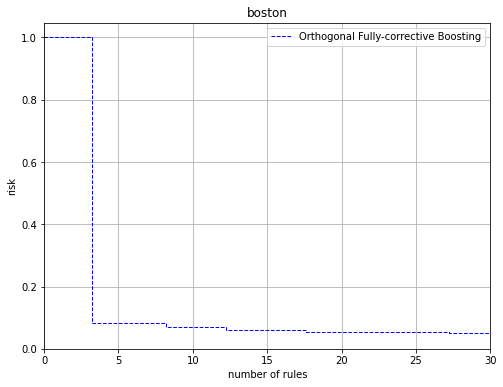

30.46778212179487
orth_fc_Newton-CG: avg train risk: 0.00699941210376676 avg test risk 0.01376793494319549 &s: 21.34
orth_fc_Newton-CG auc: 0.14133179538233237 0.1462873346513612
[4.0, 8.0, 10.8, 15.4, 22.2, 28.4, 35.2, 41.8, 47.6] [0.017012643767383435, 0.011729350593823067, 0.008660440439554867, 0.007384566056514839, 0.006453135016763312, 0.00562412026721637, 0.004929528337765171, 0.00433938187341745, 0.003860954685229093]


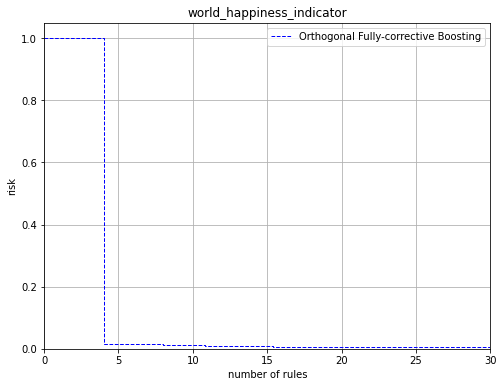

4882.764241803283
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/who_life_expectancy/who_life_expectancy_orth_fc_Newton-CG_realkd_col_5_rep1.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/who_life_expectancy/who_life_expectancy_orth_fc_Newton-CG_realkd_col_5_rep2.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/who_life_expectancy/who_life_expectancy_orth_fc_Newton-CG_realkd_col_5_rep3.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/who_life_expectancy/who_life_expectancy_orth_fc_Newton-CG_realkd_col_5_rep4.txt
orth_fc_Newton-CG: avg train risk: 0.004088261456670522 avg test risk 0.005293484120297627 &s: 25.3
orth_fc_Newton-CG auc: 0.10481808437811715 0.10590171786737072
[3.0, 9.0, 14.0, 21.0, 29.0, 32.0, 40.0, 48.0, 57.0] [0.007248069383864133, 0.005811975117412834, 0.004729215396852967, 0.004352246645236627, 0.004071758513401585, 0.003864876959658419, 0.003722157995946663, 0.00359254796855484

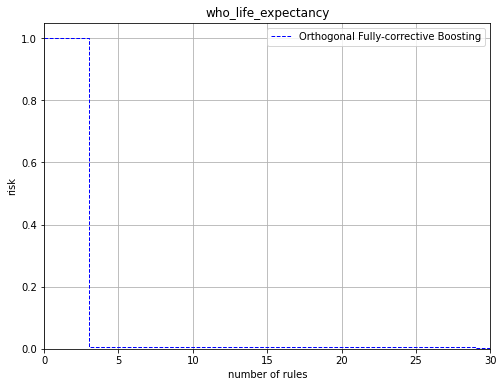

3.5
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/mobile_prices/mobile_prices_orth_fc_Newton-CG_realkd_col_4_rep1.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/mobile_prices/mobile_prices_orth_fc_Newton-CG_realkd_col_4_rep2.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/mobile_prices/mobile_prices_orth_fc_Newton-CG_realkd_col_4_rep3.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/mobile_prices/mobile_prices_orth_fc_Newton-CG_realkd_col_4_rep4.txt
orth_fc_Newton-CG: avg train risk: 0.0932027112310185 avg test risk 0.09987052940452215 &s: 12.1
orth_fc_Newton-CG auc: 0.16303367475790628 0.16982988575077548
[2.0, 5.0, 7.0, 10.0, 13.0, 16.0, 19.0, 23.0, 26.0] [0.1176203124999999, 0.10451937746588293, 0.10451937746586949, 0.10381475925135342, 0.10212694211181993, 0.10011005117407958, 0.09992430143934435, 0.09986800906866293, 0.09952398183317238]


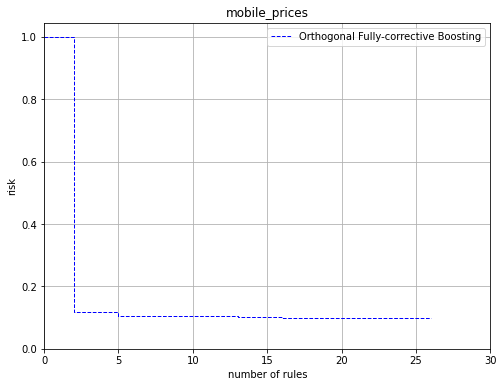

523.7783290690134
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/suicide_rates_cleaned/suicide_rates_cleaned_orth_fc_Newton-CG_realkd_col_3_rep1.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/suicide_rates_cleaned/suicide_rates_cleaned_orth_fc_Newton-CG_realkd_col_3_rep2.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/suicide_rates_cleaned/suicide_rates_cleaned_orth_fc_Newton-CG_realkd_col_3_rep3.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/suicide_rates_cleaned/suicide_rates_cleaned_orth_fc_Newton-CG_realkd_col_3_rep4.txt
orth_fc_Newton-CG: avg train risk: 0.46580112019467673 avg test risk 0.44763044945743286 &s: 12.0
orth_fc_Newton-CG auc: 0.5631283040066558 0.5451119882305206
[3.0, 5.0, 8.0, 10.0, 13.0, 15.0, 19.0, 22.0, 25.0] [0.5805259634454505, 0.5255419232029694, 0.5115348534711834, 0.5073682683285637, 0.5073682683285695, 0.5065230941851655, 0.50641249085991, 0.5063755874152488, 0.50

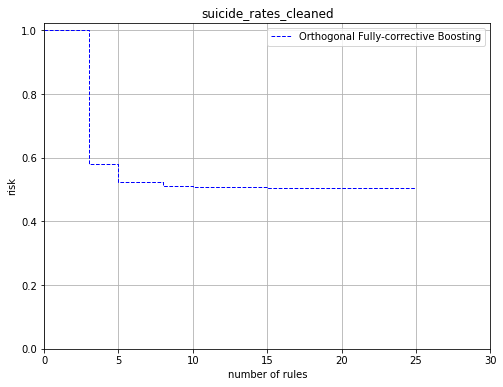

2.70680865164444
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/videogamesales/videogamesales_orth_fc_Newton-CG_realkd_col_3_rep1.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/videogamesales/videogamesales_orth_fc_Newton-CG_realkd_col_3_rep2.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/videogamesales/videogamesales_orth_fc_Newton-CG_realkd_col_3_rep3.txt
orth fc Newton-CG does not exist: 
../experiment_output_normalised_/videogamesales/videogamesales_orth_fc_Newton-CG_realkd_col_3_rep4.txt
orth_fc_Newton-CG: avg train risk: 0.8443264393856169 avg test risk 0.6369679323825459 &s: 8.6
orth_fc_Newton-CG auc: 0.942264197989992 0.7272259585937614
[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 14.0, 16.0] [0.9381466722001659, 0.9381397151987425, 0.9381397151987422, 0.9381397151987422, 0.9381397151987422, 0.9381397151987422, 0.9381397151987422, 0.9381397152648069, 0.9381397151987422]


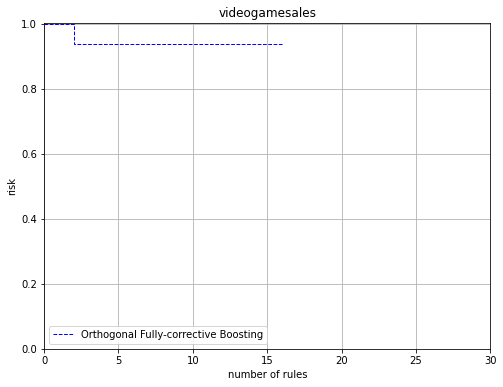

32.41651031894934
orth_fc_Newton-CG: avg train risk: 0.013835688693268785 avg test risk 0.013856459056969472 &s: 12.98
orth_fc_Newton-CG auc: 0.1137579250695731 0.11376647329129133
[3.0, 3.0, 5.0, 8.8, 13.0, 17.0, 22.0, 26.6, 31.4] [0.016124196581838154, 0.01612419536414043, 0.015670173199472993, 0.015434103052505355, 0.015227777196732004, 0.015111613637094675, 0.01499369148397869, 0.014905680171084994, 0.014765456245840542]


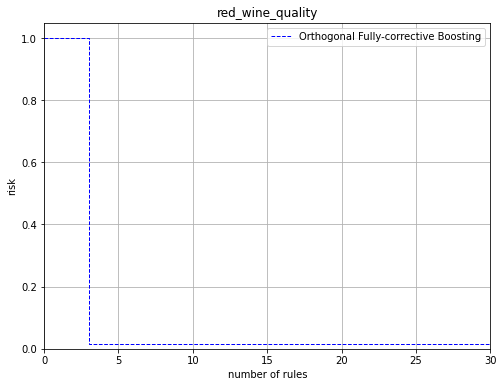

51.62076805721374
orth_fc_Newton-CG: avg train risk: 0.09660015237600582 avg test risk 0.10448405926159943 &s: 12.48
orth_fc_Newton-CG auc: 0.1777942449351748 0.18531202318521378
[2.6, 5.6, 7.6, 10.2, 13.0, 16.8, 20.2, 23.0, 25.8] [0.25181403475037134, 0.19409811926688034, 0.1597048633362434, 0.08277868312414081, 0.06357567308097925, 0.05896511748688996, 0.05570725950483829, 0.0515542024349678, 0.04780357077474689]


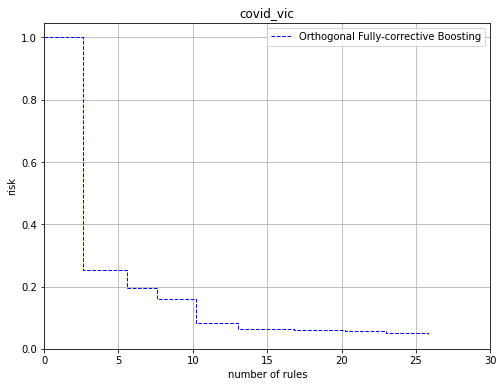

1082.8170359400497
orth_fc_Newton-CG: avg train risk: 0.28738013692274755 avg test risk 0.3996120576317398 &s: 16.56
orth_fc_Newton-CG auc: 0.4084889166491917 0.5148708392340896
[3.6, 6.6, 10.4, 14.0, 17.8, 22.2, 26.4, 30.4, 34.2] [0.5364849337775908, 0.34175088845214335, 0.32214656094839367, 0.3000331658892551, 0.2873923581306984, 0.2832272324164258, 0.27572914452982955, 0.2673190073083435, 0.25971807777479566]


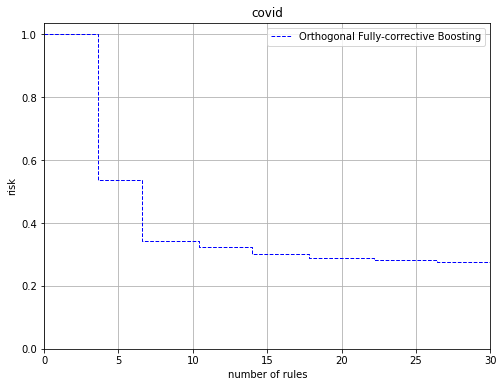

1076.416963882381
orth_fc_Newton-CG: avg train risk: 0.2337032804323068 avg test risk 0.3806556782665317 &s: 19.8
orth_fc_Newton-CG auc: 0.40096722016608694 0.5048003762766355
[4.4, 7.6, 11.8, 16.6, 21.8, 26.4, 31.4, 36.8, 41.2] [0.6367641460434064, 0.3308205693521281, 0.27443113602992336, 0.23569038588890034, 0.21216389032435584, 0.18975321980744994, 0.1675838753785243, 0.15340052068029741, 0.13642506081808245]


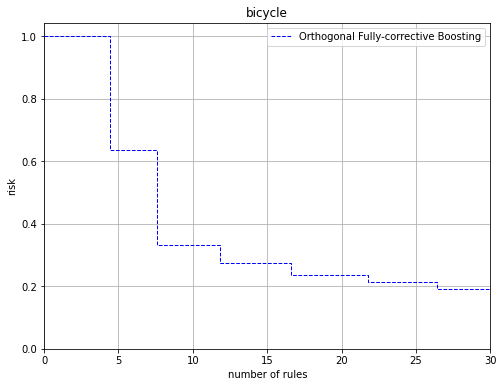

12.342277392898044
orth_fc_Newton-CG: avg train risk: 0.10340334832907246 avg test risk 0.2647464973722727 &s: 16.740000000000002
orth_fc_Newton-CG auc: 0.22341530392078582 0.3373167513645437
[3.0, 6.6, 10.6, 14.4, 18.8, 23.0, 26.8, 30.6, 33.6] [0.26571780775704174, 0.20559724934493, 0.15283994741732562, 0.12091390550708055, 0.09183138035139585, 0.06976691523041878, 0.04995842267189312, 0.041413576192000645, 0.0359942788186383]


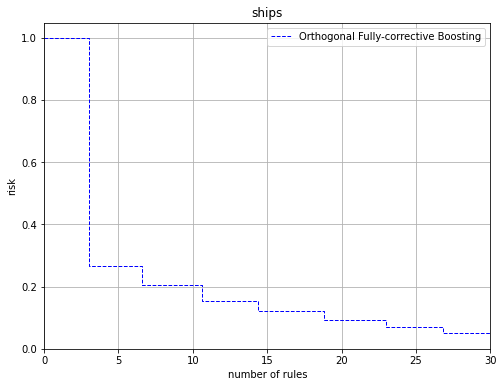

7.500299349437478
orth_fc_Newton-CG: avg train risk: 0.08412185295085385 avg test risk 0.15632487601668452 &s: 12.059999999999999
orth_fc_Newton-CG auc: 0.1421297664830711 0.21600032415345788
[2.0, 4.0, 6.8, 9.8, 13.0, 16.2, 19.6, 23.0, 26.2] [0.3032548393124188, 0.1805896649565109, 0.10281816235379601, 0.07211939599478312, 0.05444291450814668, 0.04290366085154499, 0.035260421633587676, 0.028052487904333845, 0.02177698199341642]


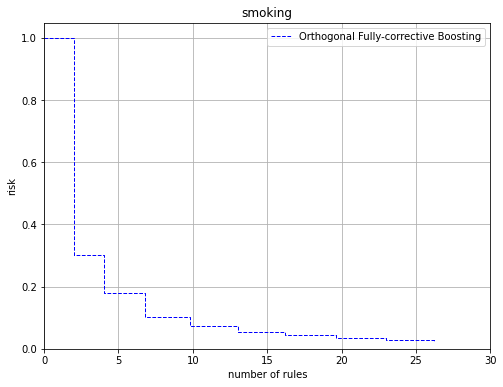

done


In [31]:
datasets = ['titanic','tic-tac-toe','iris','breast_cancer','load_wine',
            'IBM_HR', 'telco_churn', 'GenderRecognition',
            'banknote', 'liver', 'magic', 'adult', 'digits5',
            'insurance','make_friedman1',
            'make_friedman2','make_friedman3','wage', 'Demographics','gdp','used_cars','load_diabetes',
            'boston','world_happiness_indicator', 'who_life_expectancy', 'mobile_prices', 'suicide_rates_cleaned','videogamesales',
             'red_wine_quality',
            'covid_vic','covid',
            'bicycle','ships','smoking']

values = [
    'mwg_boosting_',
    'gpe_boosting_', 
    'xgb_keep_', 
    'orth_fc_Newton-CG']
print(len(datasets))
cols = [10, 10, 10, 5, 6, 
        3, 4, 3, 10, 10, 5, 5, 3,
        10, 4, 10, 10, 10,
       2, 20, 10, 5, 4, 10, 5, 4, 3, 3, 5,
        10, 10, 10, 10, 10]
max_components = [30] * len(datasets)
max_components[14]=25
max_components[15]=20
# max_components[5]=20
f = open("../analysis_results/compare_test.csv", 'w')
f2 = open("../analysis_results/compare_train.csv", 'w')
f.write('dataset'+(','+','.join(values))*4+'\n')
for i in range(len(datasets)):
#     try:
        max_risk = get_max_risk(datasets[i])
        train, test, ands, aucs_tr, aucs_te = compare_risks(datasets[i], col=cols[i], max_length=max_components[i])
        gpe_orth_test = largest_gaps(test, ands, 'gpe_boosting_', 'orth_fc_Newton-CG')
        xgb_orth_test = largest_gaps(test, ands, 'xgb_keep_', 'orth_fc_Newton-CG')
        orth_gpe_test = largest_gaps(test, ands, 'orth_fc_Newton-CG', 'gpe_boosting_')
        orth_xgb_test = largest_gaps(test, ands, 'orth_fc_Newton-CG', 'xgb_keep_')
        orth_mwg_test = largest_gaps(test, ands, 'orth_fc_Newton-CG', 'mwg_boosting_')
        mwg_orth_test = largest_gaps(test, ands, 'mwg_boosting_', 'orth_fc_Newton-CG')
        gpe_orth_train = largest_gaps(train, ands, 'gpe_boosting_', 'orth_fc_Newton-CG')
        xgb_orth_train = largest_gaps(train, ands, 'xgb_keep_', 'orth_fc_Newton-CG')
        orth_gpe_train = largest_gaps(train, ands, 'orth_fc_Newton-CG', 'gpe_boosting_')
        orth_xgb_train = largest_gaps(train, ands, 'orth_fc_Newton-CG', 'xgb_keep_')
        orth_mwg_train = largest_gaps(train, ands, 'orth_fc_Newton-CG', 'mwg_boosting_')
        mwg_orth_train = largest_gaps(train, ands, 'mwg_boosting_', 'orth_fc_Newton-CG')
        
        f.write(datasets[i] + ',')
        for value in values:
            f.write(str(max(ands[value]))+',')
        for value in values:
            f.write(str(aucs_te[value])+',')
        f.write(str(mwg_orth_test[0])+','+str(mwg_orth_test[1])+','+str(mwg_orth_test[2])+','+str(mwg_orth_test[3])+',')
        f.write(str(gpe_orth_test[0])+','+str(gpe_orth_test[1])+','+str(gpe_orth_test[2])+','+str(gpe_orth_test[3])+',')
        f.write(str(xgb_orth_test[0])+','+str(xgb_orth_test[1])+','+str(xgb_orth_test[2])+','+str(xgb_orth_test[3])+',')
        f.write(str(orth_mwg_test[0])+','+str(orth_mwg_test[1])+','+str(orth_mwg_test[2])+','+str(orth_mwg_test[3])+',')
        f.write(str(orth_gpe_test[0])+','+str(orth_gpe_test[1])+','+str(orth_gpe_test[2])+','+str(orth_gpe_test[3])+',')
        f.write(str(orth_xgb_test[0])+','+str(orth_xgb_test[1])+','+str(orth_xgb_test[2])+','+str(orth_xgb_test[3])+',')
        f.write('\n')
        
        f2.write(datasets[i] + ',')
        for value in values:
            f2.write(str(max(ands[value]))+',')
        for value in values:
            f2.write(str(aucs_tr[value])+',')
        f2.write(str(mwg_orth_train[0])+','+str(mwg_orth_train[1])+','+str(mwg_orth_train[2])+','+str(mwg_orth_train[3])+',')
        f2.write(str(gpe_orth_train[0])+','+str(gpe_orth_train[1])+','+str(gpe_orth_train[2])+','+str(gpe_orth_train[3])+',')
        f2.write(str(xgb_orth_train[0])+','+str(xgb_orth_train[1])+','+str(xgb_orth_train[2])+','+str(xgb_orth_train[3])+',')
        f2.write(str(orth_mwg_train[0])+','+str(orth_mwg_train[1])+','+str(orth_mwg_train[2])+','+str(orth_mwg_train[3])+',')
        f2.write(str(orth_gpe_train[0])+','+str(orth_gpe_train[1])+','+str(orth_gpe_train[2])+','+str(orth_gpe_train[3])+',')
        f2.write(str(orth_xgb_train[0])+','+str(orth_xgb_train[1])+','+str(orth_xgb_train[2])+','+str(orth_xgb_train[3])+',')
        f2.write('\n')

f.close()
f2.close()
print('done')

Ablation study:

    GB -> FCGB -> Greedy FCOGB -> Optimal FCOGB

In [12]:
from matplotlib import pyplot as plt
from random import random

def compare4(dataset_name, max_risk=1, repeat=5, col=10, 
            max_length=30, title=None):
    test_risks={}
    train_risks={}
    and_counts={}
    aucs_test={}
    file_numbers={}
    desc=dataset_name
    max_risk=get_max_risk(dataset_name)
    print(max_risk)
    searches=['greedy', 'exhaustive']
    for search in searches:
        location='../experiment_output_'+search
        objs = ['mwg','gpe','orth']
        for obj in objs:
            algos = ['fc'] if obj=='orth' else ['boosting', 'fc'] if obj in ['gpe'] else ['keep']
            for algo in algos:
                methods = ['Newton-CG'] if algo=='fc' else ['']
                for method in methods:
                    done = True
                    fc_train=[0]*10
                    fc_test=[0]*10
                    ands = [0]*10
                    file_number=0
                    for i in range(repeat):
                        filename = dataset_name + '_' + obj + '_' + algo + '_' + method + '_realkd_col_' + \
                            str(col) + '_rep' + str(i) + '.txt'
                        try:
                            f = open(location+'/'+dataset_name+'/'+filename, 'r')
                            file_number+=1
                        except:
                            continue
                        j=-1
                        for line in f:
                            if 'iteration ' in line:
                                j+=1
                            if j>=10:
                                break
                            words=line.split(' ')
                            if 'fc train risk' in line:
                                fc_train[j] += float(words[-1])
                            elif 'fc test risk' in line:
                                fc_test[j] += float(words[-1])
                            if 'if' in line:
                                ands[j]+=line.count('=')+1
                    if done:
                        file_numbers[search+'_'+obj + '_' + algo + '_' + method] = file_number
                        train_risks[search+'_'+obj + '_' + algo + '_' + method]=fc_train
                        test_risks[search+'_'+obj + '_' + algo + '_' + method]=fc_test
                        and_counts[search+'_'+obj + '_' + algo + '_' + method]=ands
                        if file_number==0:
                            continue
                        print(obj + '_' + algo + '_' + method+': avg train risk:',sum(fc_train)/10/max_risk/file_number, 
                              'avg test risk', sum(fc_test)/10/max_risk/file_number, '&s:', sum(ands)/10/file_number)

    rg=list(range(1,11))
    plt.figure(figsize=(8,6))
    colours = {}
    line_width = {}
    width = [1,1, 1, 1]*4
    i = 0
    colors=['blue','green','red','deepskyblue','gold','violet','cyan','brown','deepskyblue','purple', 'lime',
            'slategray','magenta','pink','olive','khaki']
    label_map={'greedy_gpe_boosting_':'Gradient Boosting', 'greedy_gpe_fc_Newton-CG': 'Gradient Fully-corrective Boosting', 
               'greedy_orth_fc_Newton-CG': 'Greedy Orthogonal Fully-corrective Boosting', 'xgb_keep_': 'XGBoost', 
              'xgb_fc_Newton-CG': 'XG Fully-corrective Boosting', 'exhaustive_gpe_boosting_':'Optimal Gradient Boosting', 
               'exhaustive_gpe_fc_Newton-CG': 'Optimal Gradient Fully-corrective Boosting',
               'exhaustive_orth_fc_Newton-CG': 'Optimal Orthogonal Fully-corrective Boosting',
               'greedy_mwg_boosting_':'Gradient Descent',
               'exhaustive_mwg_boosting_': 'Optimal Gradient Descent',
               'greedy_mwg_fc_Newton-CG':'FC Gradient Descent',
               'exhaustive_mwg_fc_Newton-CG': 'Optimal FC Gradient Descent',
              }
    for item in train_risks:
        color = colors[i]
        colours[item] = color
        line_width[item] = width[i]
        i+=1
        if file_numbers[item]==0:
            continue
        train_risks[item] = [risk / max_risk/file_numbers[item] for risk in train_risks[item]]
        test_risks[item] = [risk / max_risk/file_numbers[item] for risk in test_risks[item]]
        and_counts[item] = [ands / file_numbers[item] for ands in and_counts[item]]
        aucs_test[item] = and_counts[item][0]+sum((test_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                                   min(max_length, and_counts[item][m]))
                                for m in range(len(test_risks[item])-1))
        aucs_train[item] = and_counts[item][0]+sum((train_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                                   min(max_length, and_counts[item][m]))
                                for m in range(len(train_risks[item])-1))
        if and_counts[item][-1]<max_length:
            aucs_test[item]+=test_risks[item][-1]*(max_length-and_counts[item][-1])
            aucs_train[item]+=train_risks[item][-1]*(max_length-and_counts[item][-1])
        print(item, 'auc:', aucs_test[item])
        plt.step([0]+and_counts[item], [1]+train_risks[item], '--', color=colours[item],
                 label=label_map[item],linewidth=line_width[item],where='post')
    plt.title(dataset_name if title is None else title + " risks")
    plt.xlabel('number of rules')
    plt.xlim(0,30)
    plt.ylabel('risk')
    plt.yscale('log')
    plt.grid(visible=True, which='major')
    plt.grid(visible=True, which='minor')
    plt.gca().set_ylim(bottom=0)
    plt.legend()
    
    return train_risks, test_risks, and_counts, aucs_test, aucs_train


The next three functions computes the largest gaps from one algorithm to another.

In [13]:
def map_size_risk(train_risks, sizes):
    risks = [1]
    szs = [0]
    sz = 0
    for i in range(len(sizes)):
        while sz<=sizes[i]:
            sz+=0.2
            szs.append(sz)
            if i==0:
                risk=1
            else:
                risk=train_risks[i-1]
            risks.append(risk)
    return risks, szs


def largest_gaps(train_risks, and_counts, a, b, max_size=150):
    risks_a, szs_a = map_size_risk(train_risks[a], and_counts[a])
    risks_b, szs_b = map_size_risk(train_risks[b], and_counts[b])
    max_risk_index_ab = -1000
    max_diff=-100
    for i in range(min([len(szs_a), len(szs_b), max_size])):
        if i <= 25:
            continue
        if risks_a[i]!=1 and risks_b[i]!=1:
            if risks_a[i]-risks_b[i]>max_diff:
                max_risk_index_ab=i
                max_diff = risks_a[i]-risks_b[i]
    print(max_risk_index_ab)
    print(risks_a[max_risk_index_ab], risks_b[max_risk_index_ab])
    return risks_a[max_risk_index_ab]-risks_b[max_risk_index_ab], szs_a[max_risk_index_ab], risks_a[max_risk_index_ab], risks_b[max_risk_index_ab], max_risk_index_ab


def internal_steps(train_risks, and_counts, a, b, max_risk_index_ab):
    risks_a, szs_a = map_size_risk(train_risks[a], and_counts[a])
    risks_b, szs_b = map_size_risk(train_risks[b], and_counts[b])
    return  risks_a[max_risk_index_ab]-risks_b[max_risk_index_ab], szs_a[max_risk_index_ab], risks_a[max_risk_index_ab], risks_b[max_risk_index_ab]

In [16]:
values = ['greedy_gpe_boosting_', 
          'greedy_gpe_fc_Newton-CG', 
              'greedy_orth_fc_Newton-CG', 
               'exhaustive_orth_fc_Newton-CG',
          'exhaustive_gpe_boosting_',
         ]
datasets = ['titanic','tic-tac-toe','iris','breast_cancer',
            'IBM_HR', 'telco_churn', 'GenderRecognition',
            'banknote', 'liver', 'magic', 'adult', 'digits5',
            'insurance','make_friedman1',
            'make_friedman2','make_friedman3','wage', 'Demographics','gdp','used_cars','load_diabetes',
            'boston','world_happiness_indicator', 'who_life_expectancy', 'mobile_prices', 'suicide_rates_cleaned',
            'videogamesales', 'red_wine_quality',
            'covid_vic','covid',
            'bicycle','ships','smoking']
cols = [10, 10, 10, 5, 
        3, 4, 3, 10, 10, 5, 5, 3,
        10, 4, 10, 10, 10,
       2, 20, 10, 5, 4, 10, 5, 4, 3, 3, 5,
        10, 10, 10, 10, 10]
print(len(cols))
datapoints = [891,958,150,569,178,1470, 7043, 3168, 1372, 345, 19020, 30162, 5620,
              1338,1000,5000,2000,1379,8992,35,1770,442,506,156, 2928, 2000, 27820, 16598, 1599, 
              85,225,122,34,36]

max_components = [30] * len(datasets)
max_components[11]=25
max_components[12]=25
f = open("../analysis_results/ablation_te.csv", 'w')
f.write('dataset'+(','+','.join(values))*4+'\n')
f2 = open("../analysis_results/ablation_tr.csv", 'w')
f2.write('dataset'+(','+','.join(values))*4+'\n')
for i in range(len(datasets)):
    try:
        print(datasets[i])
        max_risk = get_max_risk(datasets[i])
        train, test, ands, aucs_te, aucs_tr = compare4(datasets[i], col=cols[i], max_length=max_components[i])
        gpe_orth_test = largest_gaps(test, ands, 'exhaustive_gpe_boosting_', 'exhaustive_orth_fc_Newton-CG')
        orth_gpe_test = largest_gaps(test, ands, 'exhaustive_orth_fc_Newton-CG', 'exhaustive_gpe_boosting_')
        gpe_fc_test = internal_steps(test, ands, 'exhaustive_gpe_boosting_', 'greedy_gpe_fc_Newton-CG', gpe_orth[4])
        fc_gpe_test = internal_steps(test, ands, 'greedy_gpe_fc_Newton-CG', 'exhaustive_gpe_boosting_', orth_gpe_test[4])
        fc_orth_test = internal_steps(test, ands, 'greedy_gpe_fc_Newton-CG', 'greedy_orth_fc_Newton-CG', gpe_orth[4])
        orth_fc_test = internal_steps(test, ands, 'greedy_orth_fc_Newton-CG', 'greedy_gpe_fc_Newton-CG', orth_gpe_test[4])
        greedy_opt_test = internal_steps(test, ands, 'greedy_orth_fc_Newton-CG', 'exhaustive_orth_fc_Newton-CG', gpe_orth[4])
        opt_greedy_test = internal_steps(test, ands, 'exhaustive_orth_fc_Newton-CG', 'greedy_orth_fc_Newton-CG', orth_gpe_test[4])
        
        f.write(datasets[i] + ',')
        for value in values:
            f.write(str(max(ands[value]))+',')
        for value in values:
            f.write(str(aucs_te[value])+',')
        f.write(str(gpe_fc_test[0])+','+str(gpe_fc_test[1])+','+str(gpe_fc_test[2])+','+str(gpe_fc_test[3])+',')
        f.write(str(fc_gpe_test[0])+','+str(fc_gpe_test[1])+','+str(fc_gpe_test[2])+','+str(fc_gpe_test[3])+',')
        f.write(str(fc_orth_test[0])+','+str(fc_orth_test[1])+','+str(fc_orth_test[2])+','+str(fc_orth_test[3])+',')
        f.write(str(orth_fc_test[0])+','+str(orth_fc_test[1])+','+str(orth_fc_test[2])+','+str(orth_fc_test[3])+',')
        f.write(str(greedy_opt_test[0])+','+str(greedy_opt_test[1])+','+str(greedy_opt_test[2])+','+str(greedy_opt_test[3])+',')
        f.write(str(opt_greedy_test[0])+','+str(opt_greedy_test[1])+','+str(opt_greedy_test[2])+','+str(opt_greedy_test[3])+',')
        f.write(str(gpe_orth[0])+','+str(gpe_orth[1])+','+str(gpe_orth[2])+','+str(gpe_orth[3])+',')
        f.write(str(orth_gpe_test[0])+','+str(orth_gpe_test[1])+','+str(orth_gpe_test[2])+','+str(orth_gpe_test[3])+',')
        f.write('\n')
        
        gpe_orth_train = largest_gaps(train, ands, 'exhaustive_gpe_boosting_', 'exhaustive_orth_fc_Newton-CG')
        orth_gpe_train = largest_gaps(train, ands, 'exhaustive_orth_fc_Newton-CG', 'exhaustive_gpe_boosting_')
        gpe_fc_train = internal_steps(train, ands, 'exhaustive_gpe_boosting_', 'greedy_gpe_fc_Newton-CG', gpe_orth[4])
        fc_gpe_train = internal_steps(train, ands, 'greedy_gpe_fc_Newton-CG', 'exhaustive_gpe_boosting_', orth_gpe_train[4])
        fc_orth_train = internal_steps(train, ands, 'greedy_gpe_fc_Newton-CG', 'greedy_orth_fc_Newton-CG', gpe_orth[4])
        orth_fc_train = internal_steps(train, ands, 'greedy_orth_fc_Newton-CG', 'greedy_gpe_fc_Newton-CG', orth_gpe_train[4])
        greedy_opt_train = internal_steps(train, ands, 'greedy_orth_fc_Newton-CG', 'exhaustive_orth_fc_Newton-CG', gpe_orth[4])
        opt_greedy_train = internal_steps(train, ands, 'exhaustive_orth_fc_Newton-CG', 'greedy_orth_fc_Newton-CG', orth_gpe_train[4])
        
        f2.write(datasets[i] + ',')
        for value in values:
            f2.write(str(max(ands[value]))+',')
        for value in values:
            f2.write(str(aucs_te[value])+',')
        f2.write(str(gpe_fc_train[0])+','+str(gpe_fc_train[1])+','+str(gpe_fc_train[2])+','+str(gpe_fc_train[3])+',')
        f2.write(str(fc_gpe_train[0])+','+str(fc_gpe_train[1])+','+str(fc_gpe_train[2])+','+str(fc_gpe_train[3])+',')
        f2.write(str(fc_orth_train[0])+','+str(fc_orth_train[1])+','+str(fc_orth_train[2])+','+str(fc_orth_train[3])+',')
        f2.write(str(orth_fc_train[0])+','+str(orth_fc_train[1])+','+str(orth_fc_train[2])+','+str(orth_fc_train[3])+',')
        f2.write(str(greedy_opt_train[0])+','+str(greedy_opt_train[1])+','+str(greedy_opt_train[2])+','+str(greedy_opt_train[3])+',')
        f2.write(str(opt_greedy_train[0])+','+str(opt_greedy_train[1])+','+str(opt_greedy_train[2])+','+str(opt_greedy_train[3])+',')
        f2.write(str(gpe_orth[0])+','+str(gpe_orth[1])+','+str(gpe_orth[2])+','+str(gpe_orth[3])+',')
        f2.write(str(orth_gpe_train[0])+','+str(orth_gpe_train[1])+','+str(orth_gpe_train[2])+','+str(orth_gpe_train[3])+',')
        f2.write('\n')

    except:
        continue
f.close()
print('done')

33
titanic
1.0
gpe_boosting_: avg train risk: 0.6118282572937578 avg test risk 0.6903799959890116 &s: 22.22
gpe_fc_Newton-CG: avg train risk: 0.6119285414269393 avg test risk 0.6906056313509659 &s: 21.880000000000003
orth_fc_Newton-CG: avg train risk: 0.6105959684846738 avg test risk 0.7186830683975195 &s: 21.6
gpe_boosting_: avg train risk: 0.5901303876115521 avg test risk 0.6967930638888309 &s: 27.3
gpe_fc_Newton-CG: avg train risk: 0.5880366491430367 avg test risk 0.7008725524869737 &s: 27.619999999999997
orth_fc_Newton-CG: avg train risk: 0.5940096769179378 avg test risk 0.7060952812311686 &s: 25.76
tic-tac-toe
1
gpe_boosting_: avg train risk: 0.6351372504701496 avg test risk 0.7192877625452025 &s: 22.6
gpe_fc_Newton-CG: avg train risk: 0.6290305795924229 avg test risk 0.7109624035401794 &s: 23.880000000000003
orth_fc_Newton-CG: avg train risk: 0.614342265613755 avg test risk 0.7102513097695653 &s: 24.4
gpe_boosting_: avg train risk: 0.5397645161218193 avg test risk 0.5833655812165

orth_fc_Newton-CG: avg train risk: 0.014982576616962734 avg test risk 0.015753890433513225 &s: 14.2
gpe_boosting_: avg train risk: 0.014951822549859075 avg test risk 0.016302923778737002 &s: 20.5
gpe_fc_Newton-CG: avg train risk: 0.01472388525709281 avg test risk 0.01647363482212914 &s: 24.3
orth_fc_Newton-CG: avg train risk: 0.01480847683596378 avg test risk 0.015467038970163688 &s: 22.380000000000003
covid_vic
51.62076805721374
gpe_boosting_: avg train risk: 0.11463357278118995 avg test risk 0.11263060516476828 &s: 15.6
gpe_fc_Newton-CG: avg train risk: 0.10357588818625314 avg test risk 0.10720302607276233 &s: 15.24
orth_fc_Newton-CG: avg train risk: 0.09974235460862203 avg test risk 0.1049463173461432 &s: 13.780000000000001
gpe_boosting_: avg train risk: 0.11307162110142277 avg test risk 0.10581011837941634 &s: 16.240000000000002
gpe_fc_Newton-CG: avg train risk: 0.10395835665151036 avg test risk 0.10410631891355408 &s: 16.32
orth_fc_Newton-CG: avg train risk: 0.10122063082559463 av

/tmp/ipykernel_12401/3624857710.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

The next cell contains information copied from "../analysis_results/ablation.csv"

In [17]:
sobc_s_tr=[ 0.647235376, 0.730860317, 0.799414394, 0.347304187, 1, 0.60229175, 0.834034523, 0.99982025, 0.257477808, 0.759072711, 0.755666211, 0.809681325, 0.438306947, 0.293338496, 0.092480269, 0.377630939, 0.040842982, 0.43344679, 0.210060048, 0.008228215, 0.433511162, 0.172192669, 0.111879207, 0.027924789, 0.01063357, 0.358464174, 0.691383103, 0.952094529, 0.018361956, 0.353681493, 0.432556002, 0.495503794, 0.460797543, 0.421743923]
xobc_x_tr=[ 1, 0.560237926, 0.728851218, 0.40520651, 0.613777952, 0.629428953, 0.673028883, 0.996569179, 0.259545887, 0.600584726, 0.708955965, 0.683441837, 0.473827881, 0.350132077, 0.10580903, 0.153170807, 0.051921184, 0.484284884, 0.215529506, 0.008031839, 0.206621583, 0.20383851, 0.149077556, 0.040584198, 0.015813397, 0.162821205, 0.530081995, 0.952094533, 0.017201019, 0.365765398, ]
gobc_g_tr=[ 1, 0.492682531, 0.670668727, 0.19118436, 1, 0.609348418, 0.735775967, 0.998151977, 0.320473543, 1, 0.715826599, 0.629694074, 0.398863006, 0.350132077, 0.10580903, 0.153170792, 0.051921184, 0.484284884, 0.215529516, 0.008031822, 0.206621571, 0.20383851, 0.149077556, 0.040584198, 0.015813397, 0.162821205, 0.53008201, 0.952094529, 0.017201052, 0.165515112, 0.28398386, 0.330820569, 0.130630112, 0.152859071  ]
gfbc_g_tr=[ 0.794661558, 0.492682531, 0.670668727, 0.215761049, 0.609348418, 0.735775967, 0.998151977, 0.320473543, 0.841522206, 0.715826599, 0.629694074, 0.398863006, 0.350132077, 0.10580903, 0.153170792, 0.051921184, 0.484284884, 0.215529516, 0.008031822, 0.206621571, 0.20383851, 0.149077556, 0.040584198, 0.015813397, 0.162821205, 0.53008201, 0.952094529, 0.017201052, 0.165515112, 0.308996779, 0.330820569, 0.130630112, 0.152859071 ]
fgbc_f_tr=[ 0.794662531, 0.570573263, 0.478697855, 0.201786961, 0.580021799, 0.698593022, 0.998191972, 0.23567532, 0.825106961, 0.713285564, 0.629692538, 0.361739604, 0.350132077, 0.10580903, 0.086118576, 0.051921184, 0.484284884, 0.208662265, 0.005552462, 0.188293139, 0.20383851, 0.149077556, 0.022943698, 0.015813397, 0.162821205, 0.521696382, 0.952047056, 0.017291532, 0.089921624, 0.308369857, 0.287241492, 0.056498644, 0.152859071 ]
gebc_g_tr=[ 0.794662531, 0.553749789, 0.465179226, 0.195002628, 0.580020478, 0.683925933, 0.998191972, 0.340477057, 0.823494155, 0.713285564, 0.569870414, 0.361739604, 0.164425321, 0.075347718, 0.074919173, 0.032447574, 0.314408263, 0.208662265, 0.004592891, 0.111950602, 0.143378706, 0.081865126, 0.01838677, 0.007248069, 0.162821205, 0.521696382, 0.952047056, 0.016618201, 0.082778683, 0.29257456, 0.289524093, 0.040231992, 0.109953011 ]

sobc_o_tr=[ 0.570854537, 0.422991079, 0.402350825, 0.320294225, 0.674293271, 0.580020478, 0.772266337, 0.998191972, 0.14924596, 0.687432168, 0.713285564, 0.658367032, 0.411902612, 0.164425321, 0.075347718, 0.218852118, 0.031563124, 0.387771226, 0.199947985, 0.004592891, 0.268413594, 0.138486112, 0.081865126, 0.017012644, 0.007248069, 0.162821205, 0.614736424, 0.952047056, 0.016124197, 0.251814035, 0.341750888, 0.330820569, 0.265717808, 0.180589665  ]
xobc_o_tr=[0.82424626, 0.356129237, 0.402350825, 0.320294225, 0.233631531, 0.580020478, 0.646049192, 0.996121329, 0.14924596, 0.532959276, 0.689751925, 0.616645065, 0.411902612, 0.164425321, 0.075347718, 0.074919173, 0.031563124, 0.387771226, 0.208662265, 0.004592891, 0.111919317, 0.138486112, 0.081865126, 0.017012644, 0.007248069, 0.117620313, 0.507368268, 0.952047056, 0.016124197, 0.330820569, ]
gobc_o_tr=[ 0.82424626, 0.356129237, 0.402350825, 0.153794955, 0.674293271, 0.580020478, 0.681926215, 0.998191972, 0.207166261, 0.935490108, 0.713285564, 0.580408533, 0.367875926, 0.164425321, 0.075347718, 0.074919173, 0.031563124, 0.387771226, 0.208662265, 0.004592891, 0.111919317, 0.138486112, 0.081865126, 0.017012644, 0.007248069, 0.117620313, 0.507368268, 0.952047056, 0.016124197, 0.082778683, 0.259718078, 0.274431136, 0.069766915, 0.102818162   ]
gfbc_f_tr=[ 0.794662531, 0.570573263, 0.478697855, 0.201786961, 0.580021799, 0.698593022, 0.998191972, 0.23567532, 0.825106961, 0.713285564, 0.629692538, 0.361739604, 0.350132077, 0.10580903, 0.086118576, 0.051921184, 0.484284884, 0.208662265, 0.005552462, 0.188293139, 0.20383851, 0.149077556, 0.022943698, 0.015813397, 0.162821205, 0.521696382, 0.952047056, 0.017291532, 0.089921624, 0.308369857, 0.287241492, 0.056498644, 0.152859071 ]
fgbc_g_tr=[ 0.794662531, 0.553749789, 0.465179226, 0.195002628, 0.580020478, 0.683925933, 0.998191972, 0.340477057, 0.823494155, 0.713285564, 0.569870414, 0.361739604, 0.164425321, 0.075347718, 0.074919173, 0.032447574, 0.314408263, 0.208662265, 0.004592891, 0.111950602, 0.143378706, 0.081865126, 0.01838677, 0.007248069, 0.162821205, 0.521696382, 0.952047056, 0.016618201, 0.082778683, 0.29257456, 0.289524093, 0.040231992, 0.109953011 ]
gebc_e_tr=[ 0.672336222, 0.356129237, 0.402350825, 0.179683674, 0.580020478, 0.681926215, 0.998191972, 0.207166261, 0.788289377, 0.713285564, 0.580408533, 0.367875926, 0.164425321, 0.075347718, 0.074919173, 0.031563124, 0.387771226, 0.208662265, 0.004592891, 0.111919317, 0.138486112, 0.081865126, 0.017012644, 0.007248069, 0.117620313, 0.507368268, 0.952047056, 0.016124197, 0.082778683, 0.287392358, 0.274431136, 0.069766915, 0.102818162 ]

soa_s_tr=[ 0.701629655, 0.80461534, 0.358502344, 0.347105391, 0.285846271, 0.215040116, 0.707363441, 0.997157328, 0.393606756, 0.855941549, 0.743992134, 0.620068421, 0.409799778, 0.19059611, 0.079771964, 0.125365263, 0.060687287, 0.395823429, 0.22926942, 0.037820524, 0.170926885, 0.156711717, 0.109951846, 0.047247001, 0.040045699, 0.156505265, 0.572832294, 0.95372265, 0.048004096, 0.201345565, 0.385764534, 0.434790556, 0.211964084, 0.169859531 ]
xoa_x_tr=[ 0.689503223, 0.740291587, 0.41166092, 0.398372201, 0.35046424, 0.219943026, 0.703580335, 0.997048864, 0.394431787, 0.84066852, 0.736140861, 0.619783064, 0.38422979, 0.192359784, 0.08444077, 0.164835258, 0.059612408, 0.393691309, 0.226818851, 0.03766164, 0.223785523, 0.15997285, 0.110296537, 0.049383563, 0.040766726, 0.165500991, 0.561849454, 0.953722426, 0.04811256, 0.578550417, 0.411546037, 0.255499362 ]
goa_g_tr=[ 0.675269765, 0.692832847, 0.344019539, 0.361306252, 0.302578509, 0.21475687, 0.713688665, 0.996576183, 0.354159789, 0.833033978, 0.728922425, 0.626036513, 0.384539843, 0.192359782, 0.084440775, 0.164835253, 0.059612405, 0.393691308, 0.226818852, 0.037661639, 0.223785516, 0.159972857, 0.110296534, 0.049383566, 0.040766722, 0.165500985, 0.56184946, 0.953722426, 0.048112565, 0.191957473, 0.418921063, 0.405162596, 0.254859678, 0.155285703 ]
gfa_g_tr=[ 0.681567518, 0.737253102, 0.316034782, 0.36243086, 0.213994755, 0.713688665, 0.664802743, 0.363341786, 0.854764203, 0.732209614, 0.529805122, 0.266799644, 0.190027236, 0.093674508, 0.182552811, 0.059633591, 0.401178019, 0.189453895, 0.037005668, 0.242826664, 0.159246241, 0.113220854, 0.047539801, 0.040750483, 0.165615227, 0.372699702, 0.604639867, 0.048710293, 0.183949897, 0.434536721, 0.403810762, 0.244153792, 0.158900417]
fga_f_tr=[0.681431296, 0.736335482, 0.321728789, 0.359764778, 0.211718654, 0.701961852, 0.664878429, 0.3539947, 0.855932477, 0.732003321, 0.528356258, 0.267167629, 0.189322988, 0.092240745, 0.162787434, 0.058967596, 0.395562073, 0.193954276, 0.036847257, 0.201912035, 0.16187492, 0.107781046, 0.046861641, 0.040897531, 0.166911357, 0.440875911, 0.63637248, 0.048510147, 0.170222395, 0.426047042, 0.40144017, 0.208848948, 0.144975554]
gea_g_tr=[ 0.680076674, 0.734831808, 0.296380859, 0.355132933, 0.211693446, 0.692229527, 0.66487151, 0.35609814, 0.848167516, 0.732903506, 0.472165281, 0.267167592, 0.169270183, 0.083647864, 0.156312951, 0.057545264, 0.304517923, 0.197078473, 0.036462319, 0.188713152, 0.151146963, 0.103688859, 0.045619556, 0.039841846, 0.164704064, 0.473344682, 0.731576933, 0.047642943, 0.160643389, 0.42105661, 0.397423195, 0.202257047, 0.141460362  ]

soa_o_tr=[ 0.658264689, 0.655737097, 0.317322084, 0.3578206, 0.24072109, 0.211937584, 0.695454593, 0.996722891, 0.337198679, 0.836705417, 0.73075061, 0.607634851, 0.392723485, 0.166006733, 0.079862672, 0.148688707, 0.057184541, 0.381149522, 0.225206574, 0.037322482, 0.19128495, 0.152512924, 0.103332215, 0.046555551, 0.039597032, 0.16259785, 0.553027925, 0.953720251, 0.048015976, 0.177892656, 0.408488917, 0.40096722, 0.222729427, 0.142078008 ]
xoa_o_tr=[ 0.658264689, 0.655737097, 0.317322084, 0.3578206, 0.24072109, 0.211937584, 0.695454593, 0.996722891, 0.337198679, 0.836705417, 0.73075061, 0.607634851, 0.392723485, 0.166006733, 0.079862672, 0.148688707, 0.057184541, 0.381149522, 0.225206574, 0.037322482, 0.19128495, 0.152512924, 0.103332215, 0.046555551, 0.039597032, 0.16259785, 0.553027925, 0.953720251, 0.048015976, 0.177892656,  0.40096722, 0.142078008  ]
goa_o_tr=[ 0.658264689, 0.655737097, 0.317322084, 0.3578206, 0.24072109, 0.211937584, 0.695454593, 0.996722891, 0.337198679, 0.836705417, 0.73075061, 0.607634851, 0.392723485, 0.166006733, 0.079862672, 0.148688707, 0.057184541, 0.381149522, 0.225206574, 0.037322482, 0.19128495, 0.152512924, 0.103332215, 0.046555551, 0.039597032, 0.16259785, 0.553027925, 0.953720251, 0.048015976, 0.177892656, 0.408488917, 0.40096722, 0.222729427, 0.142078008  ]
gfa_f_tr=[ 0.681431296, 0.736335482, 0.321728789, 0.359764778, 0.211718654, 0.701961852, 0.664878429, 0.3539947, 0.855932477, 0.732003321, 0.528356258, 0.267167629, 0.189322988, 0.092240745, 0.162787434, 0.058967596, 0.395562073, 0.193954276, 0.036847257, 0.201912035, 0.16187492, 0.107781046, 0.046861641, 0.040897531, 0.166911357, 0.440875911, 0.63637248, 0.048510147, 0.170222395, 0.426047042, 0.40144017, 0.208848948, 0.144975554 ]
fga_g_tr=[ 0.680076674, 0.734831808, 0.296380859, 0.355132933, 0.211693446, 0.692229527, 0.66487151, 0.35609814, 0.848167516, 0.732903506, 0.472165281, 0.267167592, 0.169270183, 0.083647864, 0.156312951, 0.057545264, 0.304517923, 0.197078473, 0.036462319, 0.188713152, 0.151146963, 0.103688859, 0.045619556, 0.039841846, 0.164704064, 0.473344682, 0.731576933, 0.047642943, 0.160643389, 0.42105661, 0.397423195, 0.202257047, 0.141460362 ]
gea_e_tr=[ 0.658264689, 0.655737097, 0.317322084, 0.3578206, 0.211937584, 0.695454593, 0.66487151, 0.337198679, 0.836705417, 0.73075061, 0.516057482, 0.28128719, 0.166006733, 0.08676603, 0.15622218, 0.057184541, 0.381149522, 0.209853401, 0.036704382, 0.19128495, 0.152512924, 0.103332215, 0.046555551, 0.039597032, 0.16259785, 0.502392868, 0.699842034, 0.048015976, 0.17696856, 0.408488917, 0.40096722, 0.222729427, 0.141839407 ]

sowc_s_tr=[0.824246048, 0.928393084, 0.374490352, 0.347304187, 0.394804827, 0.571138882, 0.834034523, 0.997927912, 0.384761579, 0.876126747, 0.773427591, 0.809681325, 0.446001726, 0.459636007, 0.092480269, 0.377630939, 0.040842982, 0.43344679, 0.242406727, 0.004562996, 0.433511162, 0.172192669, 0.111879207, 0.027924789, 0.006993141, 0.358464174, 0.691383103, 0.953212643, 0.018361956, 0.099187669, 0.540115161, 0.672891219, 0.460797543, 0.155441087]
xowc_x_tr=[0.80289879, 0.863512299, 0.728851218, 0.325492978, 0.613777952, 0.556050964, 0.673028883, 0.997131142, 0.407202483, 0.758164381, 0.708955965, 0.61811202, 0.314136383, 0.350132077, 0.10580903, 0.153170807, 0.051921184, 0.484284884, 0.242406727, 0.00437605, 0.268413594, 0.20383851, 0.073188026, 0.011635888, 0.005739473, 0.090065945, 0.614736424, 0.953212643, 0.015318107, 0.070515942, 0.513392765, 0.297744445, 0.299172332, 0.052382266  ]
gowc_g_tr=[ 0.642742013, 0.766917063, 0.670668727, 0.583773462, 0.551741712, 0.556358866, 0.675545131, 0.995634946, 0.430814943, 0.736055937, 0.698052285, 0.658367031, 0.296666089, 0.350132077, 0.10580903, 0.153170792, 0.051921184, 0.484284884, 0.242406727, 0.004376052, 0.268413594, 0.20383851, 0.073188026, 0.011635891, 0.005739472, 0.090065934, 0.614736424, 0.953212643, 0.015318113, 0.210547461, 0.32825758, 0.164214282, 0.197408595, 0.152859071 ]
gfwc_g_tr=[ 0.642742013, 0.766917063, 0.670668727, 0.583773462, 0.556358866, 0.675545131, 0.995634946, 0.430814943, 0.736055937, 0.698052285, 0.658367031, 0.296666089, 0.350132077, 0.10580903, 0.153170792, 0.051921184, 0.484284884, 0.242406727, 0.004376052, 0.268413594, 0.20383851, 0.073188026, 0.011635891, 0.005739472, 0.162821205, 0.614736424, 0.953212643, 0.015318113, 0.210547461, 0.32825758, 0.636764146, 0.197408595, 0.152859071 ]
fgwc_f_tr=[ 0.642752493, 0.826872802, 0.698660929, 0.583792445, 0.555126132, 0.670580637, 0.995847236, 0.430820028, 0.789566563, 0.702929691, 0.658367032, 0.288090116, 0.350132077, 0.10580903, 0.125467456, 0.051921184, 0.484284884, 0.242406727, 0.005552462, 0.268413594, 0.20383851, 0.083223021, 0.014385004, 0.006757161, 0.162821205, 0.614736424, 0.953212643, 0.017291532, 0.225433834, 0.341750888, 0.651841109, 0.158675452, 0.152859071 ]
gewc_g_tr=[ 0.642752493, 0.826872802, 0.698660929, 0.583792445, 0.554083241, 0.666296512, 0.995847164, 0.430820028, 0.784862986, 0.70292969, 0.658367032, 0.288091646, 0.350132077, 0.10580903, 0.218852118, 0.051921184, 0.389471719, 0.242406727, 0.004592891, 0.268413594, 0.20383851, 0.071932405, 0.011751692, 0.005811975, 0.162821205, 0.614736424, 0.953212643, 0.015249178, 0.251814035, 0.341750888, 0.651841109, 0.159283677, 0.180589665 ]

sowc_o_tr=[0.82424626, 1, 0.402350825, 0.583792445, 0.674293271, 0.57148931, 1, 0.998191972, 0.430820028, 0.935490108, 0.804558094, 1, 0.474191408, 1, 0.10580903, 1, 0.051921184, 0.484284884, 0.242406727, 0.004592891, 1, 0.20383851, 0.149077556, 0.040584198, 0.007248069, 1, 1, 0.953212643, 0.019995122, 0.159704863, 1, 1, 1, 0.180589665    ]
xowc_o_tr=[ 0.82424626, 0.861264607, 0.772356042, 0.320294225, 0.674293271, 0.552227648, 0.681926215, 0.997019532, 0.430820028, 0.788289377, 0.713285564, 0.616645065, 0.352001235, 0.350132077, 0.10580903, 0.218852118, 0.051921184, 0.484284884, 0.242406727, 0.004592891, 0.268413594, 0.20383851, 0.081865126, 0.011729351, 0.005811975, 0.091326042, 0.614736424, 0.953212643, 0.016124197, 0.051554202, 0.283227232, 0.330820569, 0.049958423, 0.035260422 ]
gowc_o_tr=[ 0.672336222, 0.767687451, 0.772356042, 0.583792445, 0.674293271, 0.558070109, 0.681926215, 0.995847164, 0.430820028, 0.788289377, 0.713285564, 0.658367032, 0.341047486, 0.350132077, 0.10580903, 0.218852118, 0.051921184, 0.484284884, 0.242406727, 0.004592891, 0.268413594, 0.20383851, 0.081865126, 0.011729351, 0.005811975, 0.091326042, 0.614736424, 0.953212643, 0.016124197, 0.251814035, 0.341750888, 0.167583875, 0.205597249, 0.180589665 ]
gfwc_f_tr=[ 0.642752493, 0.826872802, 0.698660929, 0.583792445, 0.555126132, 0.670580637, 0.995847236, 0.430820028, 0.789566563, 0.702929691, 0.658367032, 0.288090116, 0.350132077, 0.10580903, 0.125467456, 0.051921184, 0.484284884, 0.242406727, 0.005552462, 0.268413594, 0.20383851, 0.083223021, 0.014385004, 0.006757161, 0.162821205, 0.614736424, 0.953212643, 0.017291532, 0.225433834, 0.341750888, 0.651841109, 0.158675452, 0.152859071 ]
fgwc_g_tr=[ 0.642752493, 0.826872802, 0.698660929, 0.583792445, 0.554083241, 0.666296512, 0.995847164, 0.430820028, 0.784862986, 0.70292969, 0.658367032, 0.288091646, 0.350132077, 0.10580903, 0.218852118, 0.051921184, 0.389471719, 0.242406727, 0.004592891, 0.268413594, 0.20383851, 0.071932405, 0.011751692, 0.005811975, 0.162821205, 0.614736424, 0.953212643, 0.015249178, 0.251814035, 0.341750888, 0.651841109, 0.159283677, 0.180589665 ]
gewc_e_tr=[ 0.672336222, 0.767687451, 0.772356042, 0.583792445, 0.558070109, 0.681926215, 0.995847164, 0.430820028, 0.788289377, 0.713285564, 0.658367032, 0.341047486, 0.350132077, 0.10580903, 0.218852118, 0.051921184, 0.484284884, 0.242406727, 0.004592891, 0.268413594, 0.20383851, 0.081865126, 0.011729351, 0.005811975, 0.162821205, 0.614736424, 0.953212643, 0.016124197, 0.251814035, 0.341750888, 0.636764146, 0.205597249, 0.180589665 ]



sobc_s_te=[0.70831745, 0.805853807, 0.832999672, 0.296881555, 0.416008179, 0.620820856, 0.840629118, 1.001616494, 0.289719485, 0.957481069, 0.739271676, 0.809104034, 0.417042677, 0.209111207, 0.091489344, 0.388131572, 0.043386915, 0.421319105, 0.212891927, 0.009312415, 0.450501395, 0.172019833, 0.091902173, 0.027746986, 0.010702875, 0.352393816, 0.666511664, 0.71377753, 0.019136111, 0.376272989, 0.515086575, 0.545766873, 0.501848295, 0.09430422]
xobc_x_te=[ 0.837299055, 0.629388398, 0.608570133, 0.373718044, 0.713757157, 0.665384173, 0.681423039, 1.001320418, 0.267962163, 0.949632257, 0.687236845, 0.685422922, 0.456968335, 0.339927776, 0.103251042, 0.154930516, 0.055177536, 0.469118299, 0.218561718, 0.008747079, 0.211261674, 0.204609586, 0.117345751, 0.040129167, 0.015234136, 0.184384517, 0.511934585, 0.713777526, 0.017929532,0.344536109,]
gobc_g_te=[0.84074078, 0.548564368, 0.787877062, 0.252969894, 0.709533453, 0.62001782, 0.782548255, 0.998522747, 0.358116102, 1.019526029, 0.689719591, 0.645887491, 0.380175747, 0.339927771, 0.10325104, 0.1549305, 0.055177539, 0.469118306, 0.218561731, 0.008747069, 0.211261656, 0.204609594, 0.117345741, 0.040129164, 0.015234139, 0.184384505, 0.511934595, 0.71377753, 0.017929567, 0.132941809, 0.434632718, 0.609167093, 0.34524642, 0.201536335]
gfbc_g_te=[ 0.84074078, 0.548564368, 0.787877062, 0.252969894, 0.62001782, 0.782548255, 0.998522747, 0.358116102, 1.019526029, 0.689719591, 0.645887491, 0.380175747, 0.339927771, 0.10325104, 0.1549305, 0.055177539, 0.469118306, 0.218561731, 0.008747069, 0.211261656, 0.204609594, 0.117345741, 0.040129164, 0.015234139, 0.184384505, 0.511934595, 0.71377753, 0.017929567, 0.132941809, 0.434632718, 0.609167093, 0.34524642, 0.201536335 ]
fgbc_f_te=[ 0.840688294, 0.662801749, 0.553626654, 0.211307836, 0.601755582, 0.715925417, 0.998554718, 0.265250429, 0.942896962, 0.683138502, 0.645853563, 0.340571654, 0.339927776, 0.103251042, 0.086511305, 0.055177536, 0.469118299, 0.211511145, 0.006627609, 0.200192, 0.204609586, 0.117345751, 0.030381138, 0.015234136, 0.184384517, 0.500330876, 0.713751517, 0.017367715, 0.060519531, 0.443788769, 0.662897155, 0.233715123, 0.141457345 ]
gebc_g_te=[ 0.840688294, 0.6445797, 0.686645328, 0.200630923, 0.601759891, 0.717896674, 0.998554718, 0.378485544, 0.941898278, 0.683138502, 0.578560331, 0.340571654, 0.168200009, 0.078181983, 0.074648581, 0.034358742, 0.310698947, 0.211511145, 0.005876164, 0.117683576, 0.150351589, 0.072897023, 0.019198691, 0.007899324, 0.184384517, 0.500330876, 0.713760765, 0.017378628, 0.068191565, 0.428557192, 0.662897155, 0.22752147, 0.164145638 ]

sobc_o_te=[0.634384877, 0.42433372, 0.691596042, 0.273249656, 0.280362856, 0.601759891, 0.782547923, 0.998554718, 0.148171024, 0.947342967, 0.683138502, 0.663536982, 0.386592114, 0.105414314, 0.078181983, 0.222898016, 0.034121137, 0.403939009, 0.202180344, 0.005876164, 0.272871438, 0.14623809, 0.072897023, 0.017385714, 0.007899324, 0.184384517, 0.585904315, 0.713759129, 0.016087612, 0.307930643, 0.444133322, 0.333121558, 0.425893923, 0.111036001]
xobc_o_te=[ 0.709578527, 0.368069586, 0.511525187, 0.273249656, 0.280362856, 0.600263506, 0.664471188, 0.998554718, 0.148171024, 0.947342967, 0.670620748, 0.627301089, 0.386592114, 0.168200009, 0.078181983, 0.074648581, 0.034121137, 0.403939009, 0.211511145, 0.005876164, 0.121911086, 0.14623809, 0.072897023, 0.017385714, 0.007899324, 0.125949807, 0.487480638, 0.713751517, 0.016087612,  0.333121558,  ]
gobc_o_te=[0.709578527, 0.368069586, 0.691596042, 0.237882578, 0.280362856, 0.601759891, 0.717896674, 0.998554718, 0.241339305, 0.985197464, 0.683138502, 0.586988284, 0.358772683, 0.168200009, 0.078181983, 0.074648581, 0.034121137, 0.403939009, 0.211511145, 0.005876164, 0.121911086, 0.14623809, 0.072897023, 0.017385714, 0.007899324, 0.125949807, 0.487480638, 0.713751517, 0.016087612, 0.068191565, 0.415548526, 0.609167078, 0.210166516, 0.127013821]
gfbc_f_te=[ 0.840688294, 0.662801749, 0.553626654, 0.211307836, 0.601755582, 0.715925417, 0.998554718, 0.265250429, 0.942896962, 0.683138502, 0.645853563, 0.340571654, 0.339927776, 0.103251042, 0.086511305, 0.055177536, 0.469118299, 0.211511145, 0.006627609, 0.200192, 0.204609586, 0.117345751, 0.030381138, 0.015234136, 0.184384517, 0.500330876, 0.713751517, 0.017367715, 0.060519531, 0.443788769, 0.662897155, 0.233715123, 0.141457345 ]
fgbc_g_te=[ 0.840688294, 0.6445797, 0.686645328, 0.200630923, 0.601759891, 0.717896674, 0.998554718, 0.378485544, 0.941898278, 0.683138502, 0.578560331, 0.340571654, 0.168200009, 0.078181983, 0.074648581, 0.034358742, 0.310698947, 0.211511145, 0.005876164, 0.117683576, 0.150351589, 0.072897023, 0.019198691, 0.007899324, 0.184384517, 0.500330876, 0.713760765, 0.017378628, 0.068191565, 0.428557192, 0.662897155, 0.22752147, 0.164145638 ]
gebc_e_te=[ 0.709578527, 0.368069586, 0.691596042, 0.237882578, 0.601759891, 0.717896674, 0.998554718, 0.241339305, 0.985197464, 0.683138502, 0.586988284, 0.358772683, 0.168200009, 0.078181983, 0.074648581, 0.034121137, 0.403939009, 0.211511145, 0.005876164, 0.121911086, 0.14623809, 0.072897023, 0.017385714, 0.007899324, 0.125949807, 0.487480638, 0.713751517, 0.016087612, 0.068191565, 0.415548526, 0.609167078, 0.210166516, 0.127013821 ]

soa_s_te=[0.746743062, 0.852342584, 0.462963197, 0.296787085, 0.387856614, 0.219841825, 0.692934719, 1.001005725, 0.410350227, 0.919881885, 0.727245403, 0.626327742, 0.394867198, 0.17933583, 0.080526214, 0.127697314, 0.062749426, 0.397689654, 0.231645416, 0.038658379, 0.178637106, 0.164950261, 0.095501075, 0.048489824, 0.040599188, 0.16054156, 0.549717637, 0.723390892, 0.048522656, 0.215337225, 0.477963831, 0.484178392, 0.248710405, 0.169745794]
xoa_x_te=[0.733953908, 0.781404854, 0.493621241, 0.383014262, 0.4577119, 0.229700914, 0.693856845, 1.000581698, 0.404527278, 0.944559468, 0.716615283, 0.629844194, 0.376598839, 0.18237849, 0.087465542, 0.16553302, 0.062440075, 0.417653817, 0.230166421, 0.038581145, 0.232705108, 0.170361327, 0.103016346, 0.053045277, 0.041364025, 0.172097102, 0.542988314, 0.723408257, 0.049132001, 0.603012505, 0.479315429,  0.340177482]
goa_g_te=[0.73533221, 0.734494218, 0.489789102, 0.355826044, 0.46769665, 0.221255528, 0.701370465, 0.998621231, 0.371390365, 0.985154039, 0.709673351, 0.637450792, 0.37516693, 0.182378486, 0.087465546, 0.165533015, 0.062440074, 0.417653827, 0.230166425, 0.03858813, 0.2327051, 0.170361334, 0.103016343, 0.053045273, 0.041364021, 0.172097107, 0.542988316, 0.723408261, 0.049132007, 0.182871319, 0.52095952, 0.496830812, 0.344224705, 0.250346028]
gfa_g_te=[ 0.73621324, 0.81129678, 0.468473266, 0.340534469, 0.221355609, 0.687776083, 0.665780315, 0.379582481, 0.957866713, 0.716179214, 0.539991527, 0.257310207, 0.180517244, 0.096986958, 0.183411886, 0.06233617, 0.419164661, 0.191988115, 0.037751407, 0.252592062, 0.166867728, 0.102577044, 0.053049579, 0.041334868, 0.170637701, 0.360573012, 0.461697322, 0.049253984, 0.179778272, 0.539512284, 0.469526738, 0.352772532, 0.244903723]
fga_f_te=[ 0.738670068, 0.808968758, 0.481101379, 0.337908188, 0.217393102, 0.699047932, 0.665799497, 0.369297834, 0.958058868, 0.712051137, 0.53736238, 0.256065497, 0.181092108, 0.096109128, 0.163319246, 0.061808026, 0.413239535, 0.196676364, 0.037586708, 0.208182555, 0.172884602, 0.10039603, 0.052257404, 0.041683421, 0.172521291, 0.425587331, 0.485486237, 0.049103875, 0.170746896, 0.52494846, 0.478388078, 0.456712095, 0.21042707 ]
gea_e_te=[ 0.759094382, 0.810209067, 0.503342213, 0.343555384, 0.21751232, 0.679200674, 0.665799497, 0.378585735, 0.967489358, 0.713023857, 0.480371341, 0.256065255, 0.165387059, 0.086486612, 0.156777405, 0.059539314, 0.307793845, 0.199553086, 0.037282275, 0.193728077, 0.164508467, 0.096829368, 0.049200456, 0.040592421, 0.168441678, 0.456488167, 0.55686284, 0.048371526, 0.165745248, 0.52942553, 0.467116193, 0.444598477, 0.209464758 ]

sxoa_o_te=[ 0.711586986, 0.68289907, 0.551653962, 0.351583186, 0.368128247, 0.217323868, 0.687776083, 0.99865107, 0.355499095, 1.010728599, 0.709665315, 0.619253199, 0.380625922, 0.162657445, 0.082637349, 0.149106336, 0.059952597, 0.4191576, 0.228510863, 0.038424843, 0.197885601, 0.168540124, 0.096516581, 0.051103803, 0.040574015, 0.168141428, 0.533952947, 0.723403409, 0.048343245, 0.185267615, 0.514870839, 0.504800376, 0.337599249, 0.215821562]
xoa_o_te=[0.711586986, 0.68289907, 0.551653962, 0.351583186, 0.368128247, 0.217323868, 0.687776083, 0.99865107, 0.355499095, 1.010728599, 0.709665315, 0.619253199, 0.380625922, 0.162657445, 0.082637349, 0.149106336, 0.059952597, 0.4191576, 0.228510863, 0.038424843, 0.197885601, 0.168540124, 0.096516581, 0.051103803, 0.040574015, 0.168141428, 0.533952947, 0.723403409, 0.048343245, 0.185267615, 0.504800376, 0.215821562]
goa_o_te=[0.711586986, 0.68289907, 0.551653962, 0.351583186, 0.368128247, 0.217323868, 0.687776083, 0.99865107, 0.355499095, 1.010728599, 0.709665315, 0.619253199, 0.380625922, 0.162657445, 0.082637349, 0.149106336, 0.059952597, 0.4191576, 0.228510863, 0.038424843, 0.197885601, 0.168540124, 0.096516581, 0.051103803, 0.040574015, 0.168141428, 0.533952947, 0.723403409, 0.048343245, 0.185267615, 0.514870839, 0.504800376, 0.337599249, 0.215821562]
gfa_f_te=[ 0.738670068, 0.808968758, 0.481101379, 0.337908188, 0.217393102, 0.699047932, 0.665799497, 0.369297834, 0.958058868, 0.712051137, 0.53736238, 0.256065497, 0.181092108, 0.096109128, 0.163319246, 0.061808026, 0.413239535, 0.196676364, 0.037586708, 0.208182555, 0.172884602, 0.10039603, 0.052257404, 0.041683421, 0.172521291, 0.425587331, 0.485486237, 0.049103875, 0.170746896, 0.52494846, 0.478388078, 0.456712095, 0.21042707 ]
fga_g_te=[ 0.759094382, 0.810209067, 0.503342213, 0.343555384, 0.21751232, 0.679200674, 0.665799497, 0.378585735, 0.967489358, 0.713023857, 0.480371341, 0.256065255, 0.165387059, 0.086486612, 0.156777405, 0.059539314, 0.307793845, 0.199553086, 0.037282275, 0.193728077, 0.164508467, 0.096829368, 0.049200456, 0.040592421, 0.168441678, 0.456488167, 0.55686284, 0.048371526, 0.165745248, 0.52942553, 0.467116193, 0.444598477, 0.209464758 ]
gea_g_te=[ 0.711586986, 0.68289907, 0.551653962, 0.351583186, 0.217323868, 0.687776083, 0.99865107, 0.355499095, 1.010728599, 0.709665315, 0.619253199, 0.380625922, 0.162657445, 0.082637349, 0.149106336, 0.059952597, 0.4191576, 0.228510863, 0.038424843, 0.197885601, 0.168540124, 0.096516581, 0.051103803, 0.040574015, 0.168141428, 0.533952947, 0.723403409, 0.048343245, 0.185267615, 0.514870839, 0.504800376, 0.337599249, 0.215821562 ]

sowc_s_te=[0.852773051, 0.921158722, 0.512050093, 0.296881555, 0.416008179, 0.596393877, 0.698435921, 1.000103818, 0.39574983, 0.866914982, 0.757512331, 0.608518845, 0.429271513, 0.263162926, 0.091489344, 0.034340177, 0.043386915, 0.421319105, 0.245644784, 0.004897391, 0.145841137, 0.172019833, 0.091902173, 0.027746986, 0.007303201, 0.09876615, 0.522166446, 0.713647344, 0.019136111, 0.113866278, 0.515086575, 0.326050449, 0.227979052, 0.117581811]
xowc_x_te=[0.837299055, 0.893644873, 0.266188805, 0.236448592, 0.240524637, 0.662145147, 0.655259178, 0.998754451, 0.421990672, 0.900829345, 0.659826312, 0.577308558, 0.315236546, 0.15729124, 0.103251042, 0.154930516, 0.055177536, 0.371881998, 0.245644785, 0.004468132, 0.272871438, 0.128163275, 0.061572494, 0.014533494, 0.005311329, 0.125949807, 0.585904315, 0.713647342, 0.015999689, 0.057401705, 0.693692397, 0.355922521, 0.85780201, 0.150604955]
gowc_g_te=[0.652275564, 0.895519108, 0.335717415, 0.525806397, 0.291656053, 0.588978625, 0.659729414, 0.998522747, 0.697996618, 0.973516023, 0.670121206, 0.663537378, 0.300427504, 0.157291231, 0.10325104, 0.1549305, 0.055177539, 0.371882012, 0.245644784, 0.004468136, 0.272871433, 0.128163277, 0.061572498, 0.014533488, 0.005311325, 0.184384505, 0.58590431, 0.713647344, 0.015999697, 0.175538041, 0.397634377, 0.333121563, 0.165289077, 0.263245872]
gfwc_g_te=[ 0.652275564, 0.895519108, 0.335717415, 0.525806397, 0.588978625, 0.659729414, 0.998522747, 0.697996618, 0.973516023, 0.670121206, 0.663537378, 0.300427504, 0.157291231, 0.10325104, 0.1549305, 0.055177539, 0.371882012, 0.245644784, 0.004468136, 0.272871433, 0.128163277, 0.061572498, 0.014533488, 0.005311325, 0.184384505, 0.58590431, 0.713647344, 0.015999697, 0.175538041, 0.397634377, 0.333121563, 0.165289077, 0.263245872 ]
fgwc_f_te=[ 0.691577246, 0.895504451, 0.401941938, 0.525950196, 0.611970275, 0.659128719, 0.998554718, 0.698007045, 0.95617679, 0.683023583, 0.663536981, 0.291777148, 0.15729124, 0.103251042, 0.126178646, 0.055177536, 0.353499924, 0.245644785, 0.006627609, 0.272871438, 0.130128011, 0.073824486, 0.014260316, 0.006216055, 0.184384517, 0.585904315, 0.713759129, 0.017367715, 0.252027111, 0.391296447, 0.342537045, 0.502986529, 0.263245866 ]
gewc_g_te=[ 0.693988819, 0.895504451, 0.427102517, 0.525950196, 0.603148801, 0.643696196, 0.998554718, 0.698007045, 0.975015565, 0.683023882, 0.663536982, 0.291796215, 0.168200009, 0.103251042, 0.222898016, 0.055177536, 0.261730887, 0.245644785, 0.005876164, 0.272871438, 0.127290054, 0.063642899, 0.011915743, 0.005712218, 0.184384517, 0.585904315, 0.713759129, 0.015693116, 0.307930643, 0.401213479, 0.348747779, 0.555443931, 0.306297647 ]

sowc_o_te=[0.852759935, 0.895504451, 0.691596042, 0.525950196, 0.686181511, 0.601759891, 0.717896674, 0.998554718, 0.470564862, 1.072628119, 0.794566246, 0.627301089, 0.437141311, 0.339927776, 0.103251042, 0.030884176, 0.055177536, 0.469118299, 0.245644785, 0.005876164, 0.187301278, 0.204609586, 0.117345751, 0.040129167, 0.007899324, 0.101584779, 0.500748587, 0.713759129, 0.020550817, 0.175473171, 0.720666478, 0.416549586, 0.425893923, 0.306297647]
xowc_o_te=[0.852759935, 0.895504451, 0.413067311, 0.242351985, 0.283675532, 0.65833102, 0.664471188, 0.998554718, 0.470564862, 1.072628119, 0.663216705, 0.573687192, 0.349629679, 0.168200009, 0.103251042, 0.222898016, 0.055177536, 0.385398159, 0.245644785, 0.005876164, 0.272871438, 0.135963681, 0.072897023, 0.015352118, 0.00586598, 0.125949807, 0.585904315, 0.713759129, 0.016087612, 0.055420749, 0.403337804, 0.416549586, 0.252541143, 0.115477882]
gowc_o_te=[0.673005784, 0.895504451, 0.511525187, 0.525950196, 0.283675532, 0.590932244, 0.664471188, 0.998554718, 0.698007045, 1.059799904, 0.683138502, 0.663536982, 0.334194189, 0.168200009, 0.103251042, 0.222898016, 0.055177536, 0.385398159, 0.245644785, 0.005876164, 0.272871438, 0.135963681, 0.072897023, 0.015352118, 0.00586598, 0.184384517, 0.585904315, 0.713759129, 0.016087612, 0.307930643, 0.403337804, 0.380226867, 0.262296201, 0.306297647]
gfwc_f_te=[0.691577246, 0.895504451, 0.401941938, 0.525950196, 0.611970275, 0.659128719, 0.998554718, 0.698007045, 0.95617679, 0.683023583, 0.663536981, 0.291777148, 0.15729124, 0.103251042, 0.126178646, 0.055177536, 0.353499924, 0.245644785, 0.006627609, 0.272871438, 0.130128011, 0.073824486, 0.014260316, 0.006216055, 0.184384517, 0.585904315, 0.713759129, 0.017367715, 0.252027111, 0.391296447, 0.342537045, 0.502986529, 0.263245866  ]
fgwc_g_te=[ 0.693988819, 0.895504451, 0.427102517, 0.525950196, 0.603148801, 0.643696196, 0.998554718, 0.698007045, 0.975015565, 0.683023882, 0.663536982, 0.291796215, 0.168200009, 0.103251042, 0.222898016, 0.055177536, 0.261730887, 0.245644785, 0.005876164, 0.272871438, 0.127290054, 0.063642899, 0.011915743, 0.005712218, 0.184384517, 0.585904315, 0.713759129, 0.015693116, 0.307930643, 0.401213479, 0.348747779, 0.555443931, 0.306297647 ]
gewc_e_te=[ 0.673005784, 0.895504451, 0.511525187, 0.525950196, 0.590932244, 0.664471188, 0.998554718, 0.698007045, 1.059799904, 0.683138502, 0.663536982, 0.334194189, 0.168200009, 0.103251042, 0.222898016, 0.055177536, 0.385398159, 0.245644785, 0.005876164, 0.272871438, 0.135963681, 0.072897023, 0.015352118, 0.00586598, 0.184384517, 0.585904315, 0.713759129, 0.016087612, 0.307930643, 0.403337804, 0.380226867, 0.262296201, 0.306297647 ]



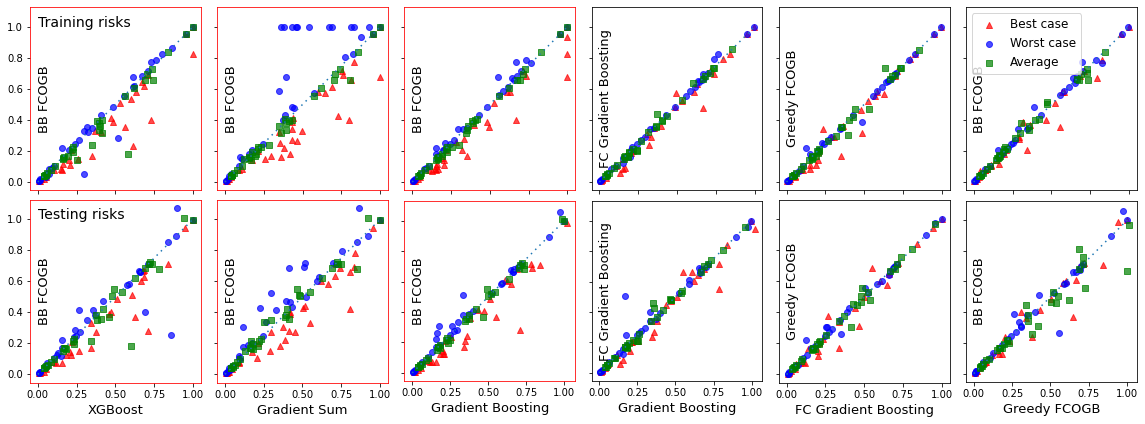

In [18]:
xs_bc_tr = [xobc_x_tr, sobc_s_tr, gobc_g_tr, gfbc_g_tr, fgbc_f_tr, gebc_g_tr, ]
ys_bc_tr = [xobc_o_tr, sobc_o_tr, gobc_o_tr, gfbc_f_tr, fgbc_g_tr, gebc_e_tr, ]
xs_avg_tr = [xoa_x_tr, soa_s_tr, goa_g_tr, gfa_g_tr, fga_f_tr, gea_g_tr, ]
ys_avg_tr = [xoa_o_tr, soa_o_tr, goa_o_tr, gfa_f_tr, fga_g_tr, gea_e_tr, ]
xs_wc_tr = [xowc_x_tr, sowc_s_tr, gowc_g_tr, gfwc_g_tr, fgwc_f_tr, gewc_g_tr, ]
ys_wc_tr = [xowc_o_tr, sowc_o_tr, gowc_o_tr, gfwc_f_tr, fgwc_g_tr, gewc_e_tr, ]
xs_bc_te = [xobc_x_te,sobc_s_te,  gobc_g_te, gfbc_g_te, fgbc_f_te, gebc_g_te, ]
ys_bc_te = [xobc_o_te, sobc_o_te, gobc_o_te, gfbc_f_te, fgbc_g_te, gebc_e_te, ]
xs_avg_te = [xoa_x_te, soa_s_te, goa_g_te, gfa_g_te, fga_f_te, gea_g_te, ]
ys_avg_te = [xoa_o_te, sxoa_o_te, goa_o_te, gfa_f_te, fga_g_te, gea_e_te, ]
xs_wc_te = [xowc_x_te, sowc_s_te, gowc_g_te, gfwc_g_te, fgwc_f_te, gewc_g_te, ]
ys_wc_te = [xowc_o_te, sowc_o_te, gowc_o_te, gfwc_f_te, fgwc_g_te, gewc_e_te, ]
xlabels=['XGBoost', 'Gradient Sum', 'Gradient Boosting', 'Gradient Boosting', 'FC Gradient Boosting', 'Greedy FCOGB']
ylabels=['BB FCOGB', 'BB FCOGB', 'BB FCOGB', 'FC Gradient Boosting', 'Greedy FCOGB', 'BB FCOGB']
fig, axs = plt.subplots(2, 6, figsize=(16,6), sharey=True, tight_layout=True, squeeze=False)
for i in range(2):
    for j in range(6):
        ax = axs[i, j]
        ax.set_aspect('equal', adjustable='box')
        if i==1:
            ax.set_xlabel(''+xlabels[j], fontsize=13)
        ax.set_ylabel(''+ylabels[j], fontsize=13)
        ax.yaxis.set_label_coords(0.12, 0.5)
        if j<3:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
        if i==0:
            ax.set_xticklabels([])
            ax.scatter(xs_bc_tr[j], ys_bc_tr[j], label='Best case', c='red', alpha=0.7, marker='^')
            ax.scatter(xs_wc_tr[j], ys_wc_tr[j], label='Worst case', c='blue', alpha=0.7,  marker='o')
            ax.scatter(xs_avg_tr[j], ys_avg_tr[j], label='Average', c='green', alpha=0.7, marker='s')
        if i==1:
            ax.scatter(xs_bc_te[j], ys_bc_te[j], label='Best case', c='red', alpha=0.7,marker='^')
            ax.scatter(xs_wc_te[j], ys_wc_te[j], label='Worst case', c='blue', alpha=0.7,  marker='o')
            ax.scatter(xs_avg_te[j], ys_avg_te[j], label='Average', c='green', alpha=0.7,  marker='s')
        ax.plot([0,1], [0,1], linestyle=(0, (1,3)))
axs[0,5].legend(fontsize=12)
axs[0, 0].text(0, 1, 'Training risks', fontsize=14)
axs[1, 0].text(0, 1, 'Testing risks', fontsize=14)
plt.show()
fig.savefig('ablation_study.pdf') 

In [24]:
from matplotlib import pyplot as plt
from random import random

def compare_risks_greedy(dataset_name, location='../experiment_output_20230413_', max_risk=1, repeat=5, col=10, 
            max_length=30, title=None):
    test_risks={}
    train_risks={}
    and_counts={}
    aucs_test={}
    aucs_train={}
    file_numbers={}
    desc=dataset_name
    max_risk=get_max_risk(dataset_name)
    print(max_risk)
    objs = ['mwg','gpe','xgb','orth']
    for obj in objs:
        algos = ['fc'] if obj=='orth' else ['boosting'] if obj in ['gpe', 'mwg'] else ['keep']
        searches = ['greedy'] if obj in ['mwg', 'gpe'] else ['greedy', 'exhaustive'] if obj=='orth' else ['exhaustive']
        for search in searches:
            for algo in algos:
                methods = ['Newton-CG'] if algo=='fc' else ['']
                for method in methods:
                    done = True
                    fc_train=[0]*9
                    fc_test=[0]*9
                    ands = [0]*9
                    file_number=0
                    for i in range(repeat):
                        filename = dataset_name + '_' + obj + '_' + algo + '_' + method + '_realkd_col_' + \
                            str(col) + '_rep' + str(i) + '.txt'
                        try:
                            f = open(location+search+'/'+dataset_name+'/'+filename, 'r')
                            file_number+=1
                        except:
                            print(obj, algo, method,'does not exist: ')
                            print(location+search+'/'+dataset_name+'/'+filename)
                            continue
                        j=-1
                        for line in f:
                            if 'iteration ' in line:
                                j+=1
                            if j>=9:
                                break
                            words=line.split(' ')
                            if 'fc train risk' in line:
                                fc_train[j] += float(words[-1])
                            elif 'fc test risk' in line:
                                fc_test[j] += float(words[-1])
                            if 'if' in line:
                                ands[j]+=line.count('=')+1
                    if done:
                        file_numbers[obj + '_' + algo + '_' + method+'_'+search] = file_number
                        train_risks[obj + '_' + algo + '_' + method+'_'+search]=fc_train
                        test_risks[obj + '_' + algo + '_' + method+'_'+search]=fc_test
                        and_counts[obj + '_' + algo + '_' + method+'_'+search]=ands
                        if file_number==0:
                            continue
                        print(obj + '_' + algo + '_' + method+': avg train risk:',sum(fc_train)/10/max_risk/file_number, 
                              'avg test risk', sum(fc_test)/10/max_risk/file_number, '&s:', sum(ands)/10/file_number)

    rg=list(range(1,11))
    plt.figure(figsize=(8,6))
    colours = {}
    line_width = {}
    width = [1,1, 1, 1]*4
    i = 0
    colors=['blue','green','red','gold','deepskyblue','violet','cyan','brown','deepskyblue','purple', 'lime',
            'slategray','magenta','pink','olive','khaki']
    label_map={'gpe_boosting__greedy':'Gradient Boosting', 'gpe_fc_Newton-CG': 'Gradient Fully-corrective Boosting', 
               'orth_fc_Newton-CG_greedy': 'Greedy FCOGB', 
               'orth_fc_Newton-CG_exhaustive': 'BB FCOGB',
               'xgb_keep__exhaustive': 'XGBoost', 
              'xgb_fc_Newton-CG': 'XG Fully-corrective Boosting',
              'mwg_boosting__greedy': 'Gradient Descent'}
    for item in train_risks:
        color = colors[i]
        colours[item] = color
        line_width[item] = width[i]
        i+=1
        if file_numbers[item]==0:
            continue
        train_risks[item] = [risk / max_risk/file_numbers[item] for risk in train_risks[item]]
        test_risks[item] = [risk / max_risk/file_numbers[item] for risk in test_risks[item]]
        and_counts[item] = [ands / file_numbers[item] for ands in and_counts[item]]
        aucs_test[item] = and_counts[item][0]+sum((test_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                 min(max_length, and_counts[item][m]))
                                for m in range(0,len(test_risks[item])-1))
        aucs_train[item] = and_counts[item][0]+sum((train_risks[item][m])*
                                             (min(max_length, and_counts[item][m+1])-
                                                 min(max_length, and_counts[item][m]))
                                for m in range(0,len(train_risks[item])-1))
        
        
        if and_counts[item][-1]<max_length:
            aucs_test[item]+=test_risks[item][-1]*(max_length-and_counts[item][-1])
            aucs_train[item]+=train_risks[item][-1]*(max_length-and_counts[item][-1])
        aucs_train[item] /= max_length
        aucs_test[item] /= max_length # min(max_length, and_counts[item][-1])
        print(item, 'auc:', aucs_train[item], aucs_test[item])
#         print(and_counts[item], train_risks[item])
        plt.step([0]+and_counts[item], [1]+train_risks[item], '--', color=colours[item],
                 label=label_map[item],linewidth=line_width[item],where='post')
#         plt.step([0]+and_counts[item], [1]+test_risks[item], color=colours[item],
#                  label=label_map[item],linewidth=line_width[item],where='post')
    plt.title(dataset_name if title is None else title + " risks")
    plt.xlabel('number of rules')
    plt.xlim(0,max_length)
    plt.ylabel('risk')
#     plt.yscale('log')
    plt.grid(visible=True, which='major')
    plt.grid(visible=True, which='minor')
    plt.gca().set_ylim(bottom=0)
    plt.legend()
    plt.show()
    
    return train_risks, test_risks, and_counts, aucs_train, aucs_test

34
1.0
mwg_boosting_: avg train risk: 0.6091817884368745 avg test risk 0.6553742181914453 &s: 14.0
gpe_boosting_: avg train risk: 0.556061581723824 avg test risk 0.6226031566908817 &s: 18.06
xgb_keep_: avg train risk: 0.5531513854285596 avg test risk 0.6317113955876974 &s: 20.82
orth_fc_Newton-CG: avg train risk: 0.5545661130965367 avg test risk 0.6463473083675285 &s: 17.54
orth_fc_Newton-CG: avg train risk: 0.5430883865436995 avg test risk 0.6334892465940709 &s: 20.580000000000002
mwg_boosting__greedy auc: 0.7016296546030787 0.7467430623308144
gpe_boosting__greedy auc: 0.6815675184166541 0.7362132400638278
xgb_keep__exhaustive auc: 0.6895032230059166 0.7339539077469663
orth_fc_Newton-CG_greedy auc: 0.6790251223977316 0.7581743032297973
orth_fc_Newton-CG_exhaustive auc: 0.6582646889082006 0.711586986238409


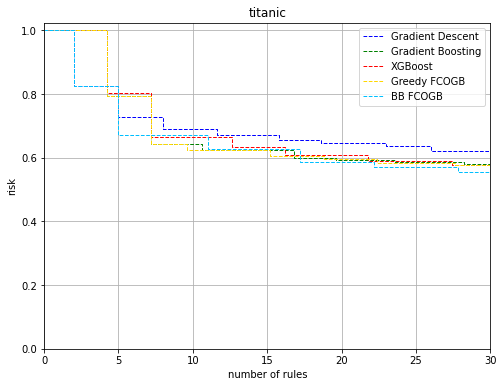

1
mwg_boosting_: avg train risk: 0.7304917596452712 avg test risk 0.7714112580047815 &s: 10.8
gpe_boosting_: avg train risk: 0.5899054640822344 avg test risk 0.6649132973139646 &s: 18.22
xgb_keep_: avg train risk: 0.5576405424693365 avg test risk 0.599808844611516 &s: 21.66
orth_fc_Newton-CG: avg train risk: 0.5818007340135668 avg test risk 0.6620355246579684 &s: 18.96
orth_fc_Newton-CG: avg train risk: 0.49894107127808585 avg test risk 0.5631054010392261 &s: 21.98
mwg_boosting__greedy auc: 0.8053953692059591 0.8533848115406723
gpe_boosting__greedy auc: 0.7372531015886016 0.8112967797705707
xgb_keep__exhaustive auc: 0.7402915872374387 0.7814048540691141
orth_fc_Newton-CG_greedy auc: 0.7348357993266081 0.809304616962241
orth_fc_Newton-CG_exhaustive auc: 0.7019073250549854 0.7509708521482357


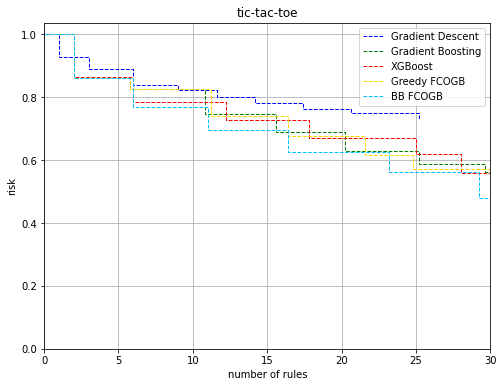

1.0
mwg_boosting_: avg train risk: 0.2788378184175181 avg test risk 0.38810158947577966 &s: 13.080000000000002
gpe_boosting_: avg train risk: 0.21403420874808332 avg test risk 0.38495157121315937 &s: 16.72
xgb_keep_: avg train risk: 0.2677958826459094 avg test risk 0.36147266613292905 &s: 15.98
orth_fc_Newton-CG: avg train risk: 0.2115349831916106 avg test risk 0.39244816223437007 &s: 14.180000000000001
orth_fc_Newton-CG: avg train risk: 0.2085287768483158 avg test risk 0.45863067894038406 &s: 17.240000000000002
mwg_boosting__greedy auc: 0.358502343978124 0.4629631971020257
gpe_boosting__greedy auc: 0.3160347819101865 0.46847326570985287
xgb_keep__exhaustive auc: 0.4116609200396361 0.4936212409778936
orth_fc_Newton-CG_greedy auc: 0.2954302676661669 0.4707021346869836
orth_fc_Newton-CG_exhaustive auc: 0.31732208374264315 0.5516539620276455


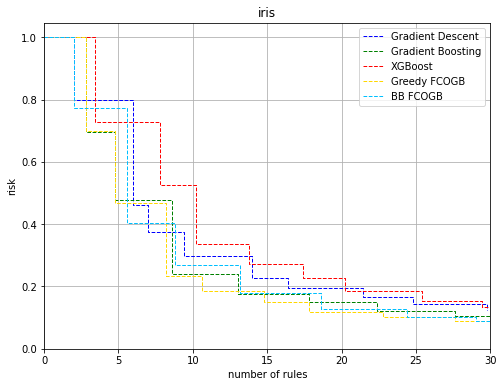

1.0
mwg_boosting_: avg train risk: 0.25422696122557914 avg test risk 0.20691306330729414 &s: 13.64
gpe_boosting_: avg train risk: 0.2379218474259969 avg test risk 0.23479347975618065 &s: 18.380000000000003
xgb_keep_: avg train risk: 0.2650015343287256 avg test risk 0.26825939025559886 &s: 19.240000000000002
orth_fc_Newton-CG: avg train risk: 0.23451113256789324 avg test risk 0.25444852770461457 &s: 19.3
orth_fc_Newton-CG: avg train risk: 0.20540929692377224 avg test risk 0.23991640497283367 &s: 23.9
mwg_boosting__greedy auc: 0.34710539119278355 0.29678708520545793
gpe_boosting__greedy auc: 0.36243085956801996 0.3405344690103474
xgb_keep__exhaustive auc: 0.3983722011171827 0.38301426209416106
orth_fc_Newton-CG_greedy auc: 0.3588161927535139 0.3558781182984641
orth_fc_Newton-CG_exhaustive auc: 0.3578205995343002 0.3515831864642321


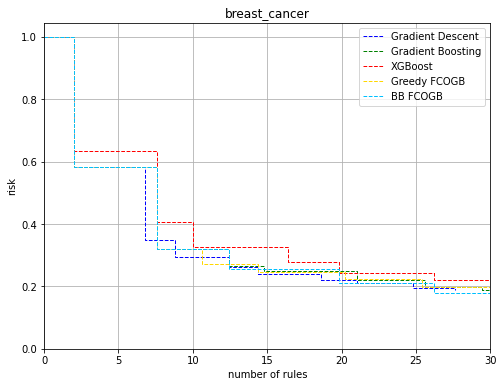

1.0
mwg_boosting_: avg train risk: 0.19809959005242436 avg test risk 0.2970019743039817 &s: 13.180000000000001
gpe_boosting_: avg train risk: 0.17614000207584923 avg test risk 0.3797986634052345 &s: 18.259999999999998
xgb_keep_: avg train risk: 0.1967090633401519 avg test risk 0.3138565721184472 &s: 17.080000000000002
orth_fc_Newton-CG: avg train risk: 0.1611975011056292 avg test risk 0.3665977981217579 &s: 16.48
orth_fc_Newton-CG: avg train risk: 0.132708747984409 avg test risk 0.28949324236145163 &s: 18.68
mwg_boosting__greedy auc: 0.2860595887165047 0.3879908402172841
gpe_boosting__greedy auc: 0.32497511669513524 0.5027657824323171
xgb_keep__exhaustive auc: 0.35046423981512304 0.45771190014696167
orth_fc_Newton-CG_greedy auc: 0.3054078242648341 0.47946359939895694
orth_fc_Newton-CG_exhaustive auc: 0.24072109032573621 0.36812824651444653


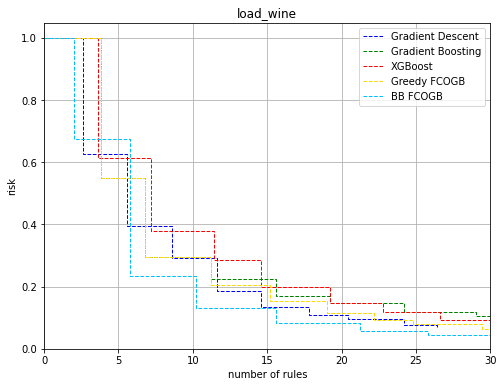

1.0
mwg_boosting_: avg train risk: 0.5308818016452309 avg test risk 0.5474678417744795 &s: 7.2
gpe_boosting_: avg train risk: 0.5213053906154861 avg test risk 0.5586480012976591 &s: 9.040000000000001
xgb_keep_: avg train risk: 0.5332699331262643 avg test risk 0.567704804033553 &s: 10.2
orth_fc_Newton-CG: avg train risk: 0.5149134625424432 avg test risk 0.548125080014618 &s: 9.2
orth_fc_Newton-CG: avg train risk: 0.5143356382702777 avg test risk 0.5402823575553499 &s: 11.02
mwg_boosting__greedy auc: 0.5924660288293448 0.611353817500439
gpe_boosting__greedy auc: 0.5837996794547919 0.629883609112354
xgb_keep__exhaustive auc: 0.5988817714570107 0.6379838170627733
orth_fc_Newton-CG_greedy auc: 0.5784572808393678 0.6199807761198358
orth_fc_Newton-CG_exhaustive auc: 0.5806955774615756 0.6101933447193122


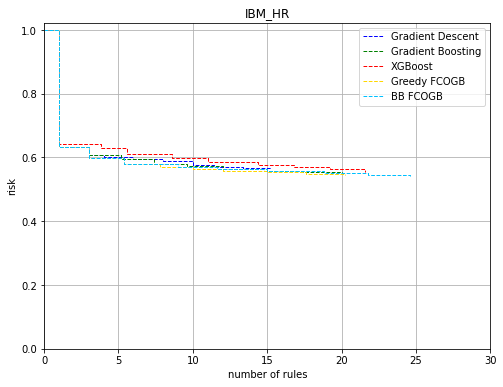

1.0
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/telco_churn/telco_churn_mwg_boosting__realkd_col_4_rep1.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/telco_churn/telco_churn_mwg_boosting__realkd_col_4_rep2.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/telco_churn/telco_churn_mwg_boosting__realkd_col_4_rep3.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/telco_churn/telco_churn_mwg_boosting__realkd_col_4_rep4.txt
mwg_boosting_: avg train risk: 0.6313392065305798 avg test risk 0.6182180061042104 &s: 11.6
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/telco_churn/telco_churn_gpe_boosting__realkd_col_4_rep1.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/telco_churn/telco_churn_gpe_boosting__realkd_col_4_rep2.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/telco_churn/telco_churn_gpe_boosting__realkd_col_4_rep3.txt
gpe boos

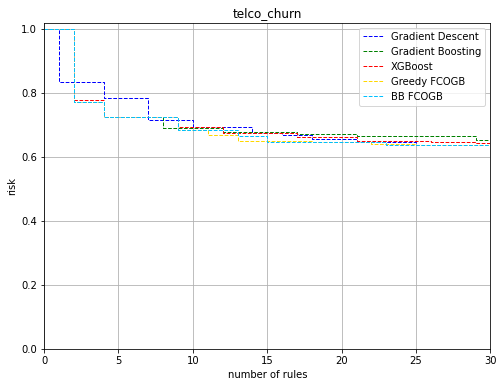

1.0
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/GenderRecognition/GenderRecognition_mwg_boosting__realkd_col_3_rep1.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/GenderRecognition/GenderRecognition_mwg_boosting__realkd_col_3_rep2.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/GenderRecognition/GenderRecognition_mwg_boosting__realkd_col_3_rep3.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/GenderRecognition/GenderRecognition_mwg_boosting__realkd_col_3_rep4.txt
mwg_boosting_: avg train risk: 0.8979072303835831 avg test risk 0.9008508731481404 &s: 6.7
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/GenderRecognition/GenderRecognition_gpe_boosting__realkd_col_3_rep1.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/GenderRecognition/GenderRecognition_gpe_boosting__realkd_col_3_rep2.txt
gpe boosting  does not exist: 
../experiment_output_20230413_gree

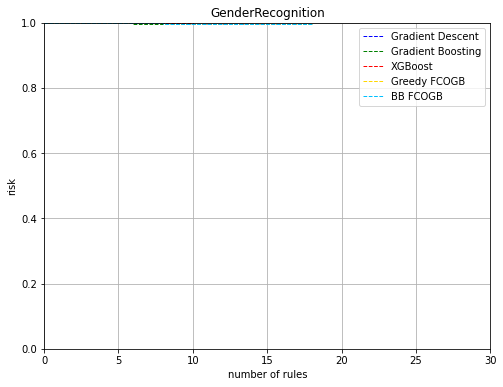

1.0
mwg_boosting_: avg train risk: 0.3164439283057251 avg test risk 0.3323706240969643 &s: 13.059999999999999
gpe_boosting_: avg train risk: 0.24634832503963752 avg test risk 0.2592192409361636 &s: 17.78
xgb_keep_: avg train risk: 0.29529489859172997 avg test risk 0.3036916294155598 &s: 14.8
orth_fc_Newton-CG: avg train risk: 0.22577325782144628 avg test risk 0.24171254073968945 &s: 18.240000000000002
orth_fc_Newton-CG: avg train risk: 0.21570686002735937 avg test risk 0.23025513182826648 &s: 18.36
mwg_boosting__greedy auc: 0.3936067555570707 0.4103502270506501
gpe_boosting__greedy auc: 0.3633417860333422 0.37958248140127193
xgb_keep__exhaustive auc: 0.39443178715167276 0.4045272783856457
orth_fc_Newton-CG_greedy auc: 0.3563743294210856 0.37830723299905633
orth_fc_Newton-CG_exhaustive auc: 0.337198679471867 0.3554990950588573


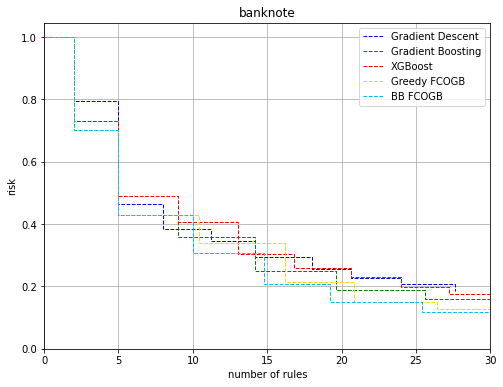

1.0
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/liver/liver_mwg_boosting__realkd_col_10_rep2.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/liver/liver_mwg_boosting__realkd_col_10_rep3.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/liver/liver_mwg_boosting__realkd_col_10_rep4.txt
mwg_boosting_: avg train risk: 0.7522279864759734 avg test risk 0.8048362398834815 &s: 14.05
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/liver/liver_gpe_boosting__realkd_col_10_rep2.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/liver/liver_gpe_boosting__realkd_col_10_rep3.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/liver/liver_gpe_boosting__realkd_col_10_rep4.txt
gpe_boosting_: avg train risk: 0.6976606843770167 avg test risk 0.8954258689774022 &s: 22.3
xgb keep  does not exist: 
../experiment_output_20230413_exhaustive/liver/liver_xgb_keep__realkd_col_10_rep2.

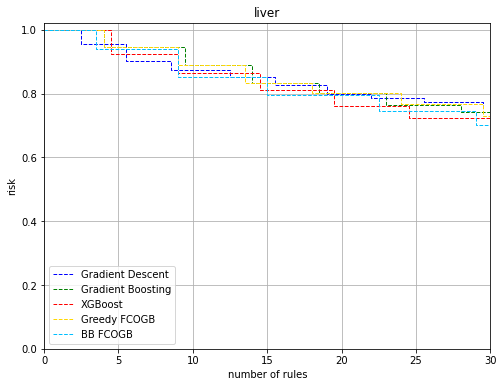

1.0
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/magic/magic_mwg_boosting__realkd_col_5_rep1.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/magic/magic_mwg_boosting__realkd_col_5_rep2.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/magic/magic_mwg_boosting__realkd_col_5_rep3.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/magic/magic_mwg_boosting__realkd_col_5_rep4.txt
mwg_boosting_: avg train risk: 0.6584725977844212 avg test risk 0.642487787965944 &s: 11.6
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/magic/magic_gpe_boosting__realkd_col_5_rep1.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/magic/magic_gpe_boosting__realkd_col_5_rep2.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/magic/magic_gpe_boosting__realkd_col_5_rep3.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/magic/magic_gpe_boosting_

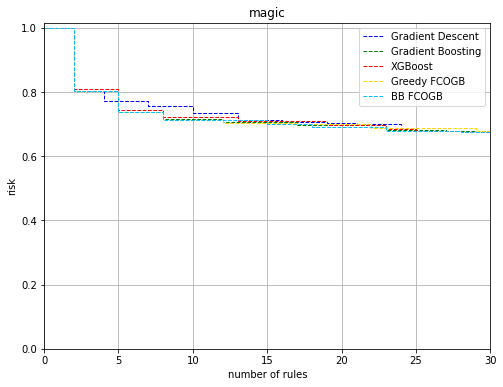

1.0
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/adult/adult_mwg_boosting__realkd_col_5_rep1.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/adult/adult_mwg_boosting__realkd_col_5_rep2.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/adult/adult_mwg_boosting__realkd_col_5_rep3.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/adult/adult_mwg_boosting__realkd_col_5_rep4.txt
mwg_boosting_: avg train risk: 0.5637278202601043 avg test risk 0.5684911930430708 &s: 9.8
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/adult/adult_gpe_boosting__realkd_col_5_rep1.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/adult/adult_gpe_boosting__realkd_col_5_rep2.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/adult/adult_gpe_boosting__realkd_col_5_rep3.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/adult/adult_gpe_boosting_

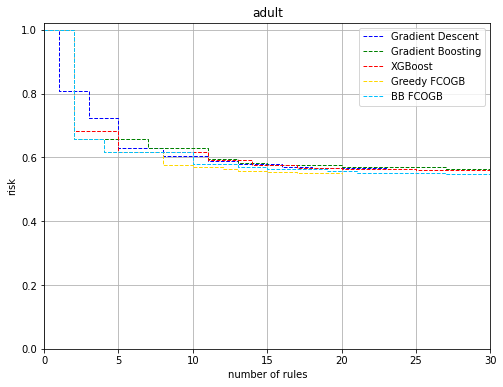

1.0
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/digits5/digits5_mwg_boosting__realkd_col_3_rep1.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/digits5/digits5_mwg_boosting__realkd_col_3_rep2.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/digits5/digits5_mwg_boosting__realkd_col_3_rep3.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/digits5/digits5_mwg_boosting__realkd_col_3_rep4.txt
mwg_boosting_: avg train risk: 0.3716078230511399 avg test risk 0.3544953406457733 &s: 6.6
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/digits5/digits5_gpe_boosting__realkd_col_3_rep1.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/digits5/digits5_gpe_boosting__realkd_col_3_rep2.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/digits5/digits5_gpe_boosting__realkd_col_3_rep3.txt
gpe boosting  does not exist: 
../experiment_output_20230413_gree

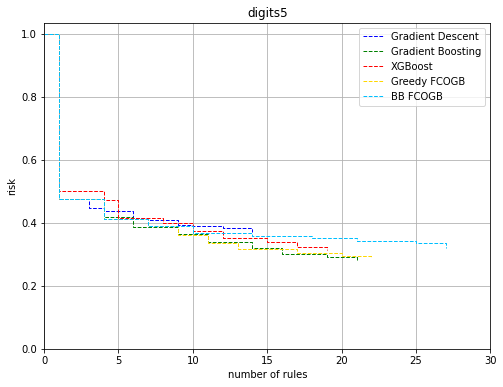

322646873.58870494
mwg_boosting_: avg train risk: 0.1740970136495936 avg test risk 0.1612460865046535 &s: 9.02
gpe_boosting_: avg train risk: 0.1204886415024411 avg test risk 0.11201719561465187 &s: 13.64
xgb_keep_: avg train risk: 0.11800302926465626 avg test risk 0.1098996963291008 &s: 15.24
orth_fc_Newton-CG: avg train risk: 0.11163495714739395 avg test risk 0.10738719337023366 &s: 10.76
orth_fc_Newton-CG: avg train risk: 0.10789186403930287 avg test risk 0.10467295145384663 &s: 12.52
mwg_boosting__greedy auc: 0.1927975395384978 0.18143449840165085
gpe_boosting__greedy auc: 0.19002723581460107 0.1805172441190385
xgb_keep__exhaustive auc: 0.19235978394748027 0.18237849049554902
orth_fc_Newton-CG_greedy auc: 0.16885435681177383 0.164673622516822
orth_fc_Newton-CG_exhaustive auc: 0.16600673321427215 0.1626574446702985


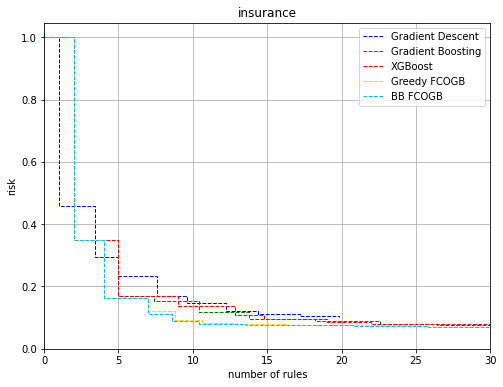

226.89125115757616
mwg_boosting_: avg train risk: 0.05665279969456347 avg test risk 0.057063224101921606 &s: 8.16
gpe_boosting_: avg train risk: 0.05511241130925728 avg test risk 0.05844486346139016 &s: 13.48
xgb_keep_: avg train risk: 0.05276636489259852 avg test risk 0.057896989812670704 &s: 15.26
orth_fc_Newton-CG: avg train risk: 0.050943348309853906 avg test risk 0.05329848335834695 &s: 10.34
orth_fc_Newton-CG: avg train risk: 0.049835873630733836 avg test risk 0.05443606887047815 &s: 15.24
mwg_boosting__greedy auc: 0.09582878056056893 0.09667987403081081
gpe_boosting__greedy auc: 0.103231061575213 0.10586108655253872
xgb_keep__exhaustive auc: 0.101328924097577 0.1049586507535766
orth_fc_Newton-CG_greedy auc: 0.09334750296751462 0.09582695986844819
orth_fc_Newton-CG_exhaustive auc: 0.09583520583374508 0.09916481853597228


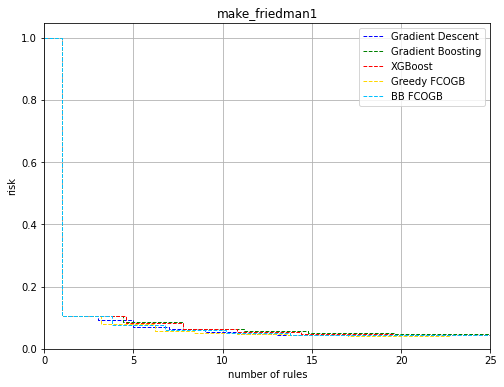

379683.4049960418
mwg_boosting_: avg train risk: 0.11129261857429965 avg test risk 0.11400440845732862 &s: 10.16
gpe_boosting_: avg train risk: 0.08198186215804273 avg test risk 0.08293615526087035 &s: 14.440000000000001
xgb_keep_: avg train risk: 0.07611776932912746 avg test risk 0.07701436513343377 &s: 14.48
orth_fc_Newton-CG: avg train risk: 0.06083811654671658 avg test risk 0.061284661223537616 &s: 12.74
orth_fc_Newton-CG: avg train risk: 0.05982812638474834 avg test risk 0.060267456559469336 &s: 13.36
mwg_boosting__greedy auc: 0.18804789507017167 0.1915459705772097
gpe_boosting__greedy auc: 0.25176078358747517 0.2528094992574146
xgb_keep__exhaustive auc: 0.2472528863860998 0.24829953010096045
orth_fc_Newton-CG_greedy auc: 0.22290179449656228 0.22355357579905374
orth_fc_Newton-CG_exhaustive auc: 0.22303306037787393 0.22365950404800133


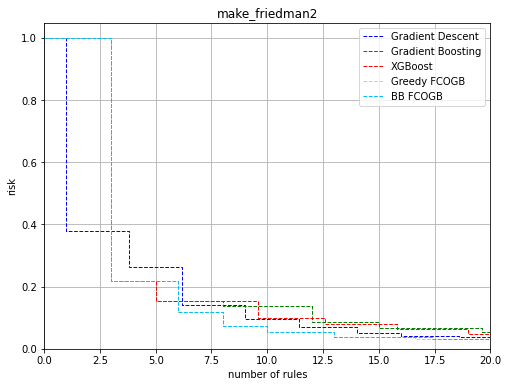

1.8780821278399789
mwg_boosting_: avg train risk: 0.026386825900698067 avg test risk 0.028350018670799077 &s: 11.22
gpe_boosting_: avg train risk: 0.023617123920224893 avg test risk 0.02615542914388481 &s: 13.540000000000001
xgb_keep_: avg train risk: 0.022915785638009466 avg test risk 0.025757984456543252 &s: 15.819999999999999
orth_fc_Newton-CG: avg train risk: 0.022144244925394456 avg test risk 0.02461652020283426 &s: 13.1
orth_fc_Newton-CG: avg train risk: 0.021606979992955872 avg test risk 0.024427065148206622 &s: 14.4
mwg_boosting__greedy auc: 0.06073367313008386 0.06279445119461605
gpe_boosting__greedy auc: 0.05963358978541941 0.062336169671020354
xgb_keep__exhaustive auc: 0.05961240775384223 0.06244007534108447
orth_fc_Newton-CG_greedy auc: 0.05748318886761545 0.06012886839456333
orth_fc_Newton-CG_exhaustive auc: 0.05718454092392885 0.059952596508722304


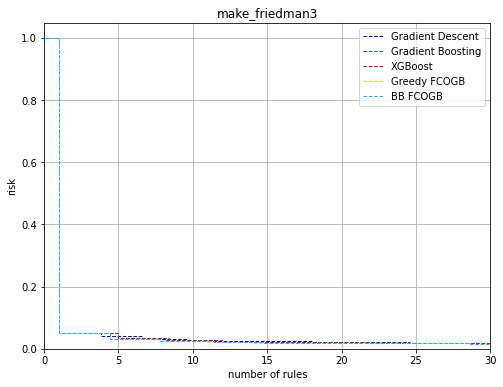

2029057842.6515312
mwg_boosting_: avg train risk: 0.3409823218695439 avg test risk 0.3415979829473042 &s: 11.48
gpe_boosting_: avg train risk: 0.32270090267555707 avg test risk 0.34800401544342596 &s: 17.02
xgb_keep_: avg train risk: 0.31102120552972135 avg test risk 0.3443269432574476 &s: 18.98
orth_fc_Newton-CG: avg train risk: 0.31299557112313553 avg test risk 0.33648641883604186 &s: 16.72
orth_fc_Newton-CG: avg train risk: 0.30211867760165856 avg test risk 0.34717651581228587 &s: 17.919999999999998
mwg_boosting__greedy auc: 0.39586970310670605 0.39773540748932745
gpe_boosting__greedy auc: 0.4011780185409925 0.41916466100677685
xgb_keep__exhaustive auc: 0.3936913091071014 0.4176538171731321
orth_fc_Newton-CG_greedy auc: 0.3861428580976643 0.40383380386969825
orth_fc_Newton-CG_exhaustive auc: 0.3811495221875275 0.4191575998018088


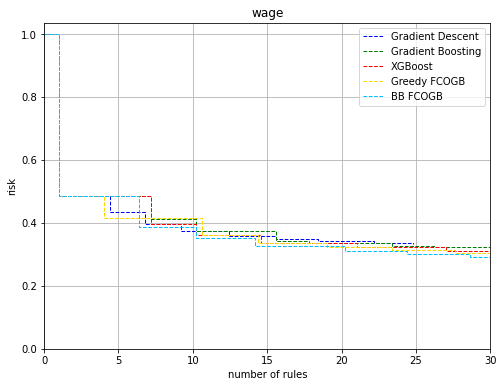

31.64835409252669
mwg_boosting_: avg train risk: 0.18649614943254295 avg test risk 0.18871686925009015 &s: 6.659999999999999
gpe_boosting_: avg train risk: 0.18316772468892803 avg test risk 0.18613238219225 &s: 9.74
xgb_keep_: avg train risk: 0.18315362923777 avg test risk 0.18612209389747522 &s: 9.86
orth_fc_Newton-CG: avg train risk: 0.18149753401150912 avg test risk 0.18421203357069318 &s: 9.879999999999999
orth_fc_Newton-CG: avg train risk: 0.18146223864311528 avg test risk 0.18431207227095503 &s: 9.940000000000001
mwg_boosting__greedy auc: 0.2294922620052354 0.23178709434156006
gpe_boosting__greedy auc: 0.22685361043372046 0.23016180428642521
xgb_keep__exhaustive auc: 0.22685988371454113 0.23020738782549297
orth_fc_Newton-CG_greedy auc: 0.2252701904591877 0.22830002959010642
orth_fc_Newton-CG_exhaustive auc: 0.22522577197671248 0.22847507733854364


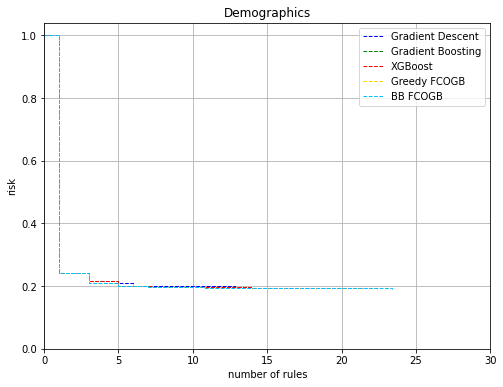

43.986571428571416
mwg_boosting_: avg train risk: 0.004725045681417392 avg test risk 0.005509393283745142 &s: 9.02
gpe_boosting_: avg train risk: 0.004614147329650385 avg test risk 0.005507724836440563 &s: 9.459999999999999
xgb_keep_: avg train risk: 0.0045632516386113035 avg test risk 0.00534192888075543 &s: 9.620000000000001
orth_fc_Newton-CG: avg train risk: 0.0040987943384597604 avg test risk 0.005265273541900262 &s: 9.64
orth_fc_Newton-CG: avg train risk: 0.004082897835060442 avg test risk 0.005066069415888547 &s: 9.86
mwg_boosting__greedy auc: 0.037826793171237716 0.038641545743113286
gpe_boosting__greedy auc: 0.03769827381926126 0.038715370030850446
xgb_keep__exhaustive auc: 0.03766647967386352 0.03856796627069856
orth_fc_Newton-CG_greedy auc: 0.037338346884841625 0.03860756139018933
orth_fc_Newton-CG_exhaustive auc: 0.037322911397410244 0.038422929168169855


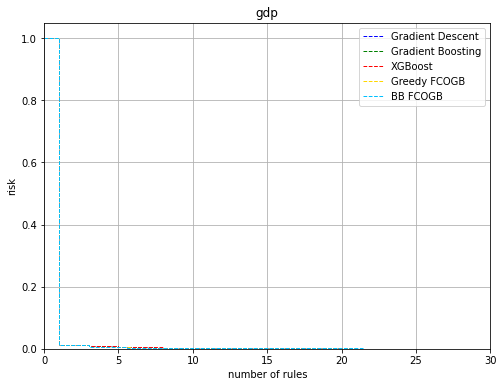

194464336.77843493
mwg_boosting_: avg train risk: 0.13317783972643502 avg test risk 0.14061731772328037 &s: 11.66
gpe_boosting_: avg train risk: 0.13075231427653666 avg test risk 0.1401206186916289 &s: 15.74
xgb_keep_: avg train risk: 0.11428577366309658 avg test risk 0.12400639219544787 &s: 15.9
orth_fc_Newton-CG: avg train risk: 0.09481287623005172 avg test risk 0.09997837122767703 &s: 12.52
orth_fc_Newton-CG: avg train risk: 0.09409859093463542 avg test risk 0.1006107210501738 &s: 13.5
mwg_boosting__greedy auc: 0.17106936749576873 0.17887810858517642
gpe_boosting__greedy auc: 0.24282666433876252 0.2525920618777514
xgb_keep__exhaustive auc: 0.2237855230503012 0.23270510806439398
orth_fc_Newton-CG_greedy auc: 0.1903537328871034 0.19556260076022447
orth_fc_Newton-CG_exhaustive auc: 0.19128494951978942 0.19788560111194703


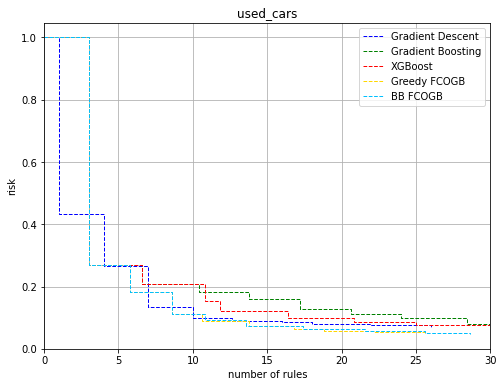

29074.481900452487
mwg_boosting_: avg train risk: 0.12150093530409092 avg test risk 0.12760850084200046 &s: 9.459999999999999
gpe_boosting_: avg train risk: 0.1157316473244634 avg test risk 0.1235432687787917 &s: 13.319999999999999
xgb_keep_: avg train risk: 0.1127463939293166 avg test risk 0.12802244416950032 &s: 17.56
orth_fc_Newton-CG: avg train risk: 0.11196625608797169 avg test risk 0.12444386626737743 &s: 12.14
orth_fc_Newton-CG: avg train risk: 0.10846797321107726 avg test risk 0.12953169218612198 &s: 16.380000000000003
mwg_boosting__greedy auc: 0.1571320067643291 0.16517282586755327
gpe_boosting__greedy auc: 0.15924624054603845 0.1668677282168879
xgb_keep__exhaustive auc: 0.15997284975248352 0.17036132732715098
orth_fc_Newton-CG_greedy auc: 0.1510774042718648 0.16462154977254503
orth_fc_Newton-CG_exhaustive auc: 0.15251292407395103 0.16854012421702466


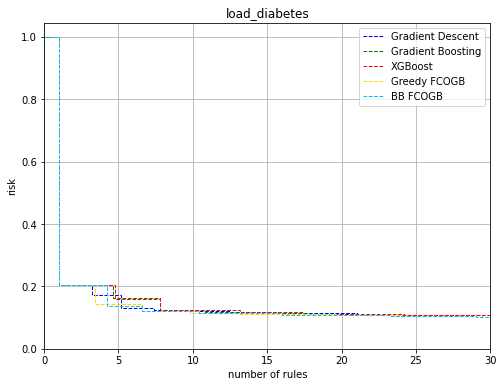

592.1469169960473
mwg_boosting_: avg train risk: 0.0781066806303161 avg test risk 0.06241345905808452 &s: 9.08
gpe_boosting_: avg train risk: 0.07063101220358936 avg test risk 0.0629711462176254 &s: 14.959999999999999
xgb_keep_: avg train risk: 0.06687118171204164 avg test risk 0.0634139571975054 &s: 16.68
orth_fc_Newton-CG: avg train risk: 0.06647278556171514 avg test risk 0.05880029337375988 &s: 14.059999999999999
orth_fc_Newton-CG: avg train risk: 0.06185727881624067 avg test risk 0.05826176562175428 &s: 16.82
mwg_boosting__greedy auc: 0.11053064323413501 0.09602382697180319
gpe_boosting__greedy auc: 0.11322085368031967 0.10257704401746964
xgb_keep__exhaustive auc: 0.11029653724440823 0.10301634603766698
orth_fc_Newton-CG_greedy auc: 0.10432194223063024 0.09532588172616162
orth_fc_Newton-CG_exhaustive auc: 0.10333221458368111 0.09651658066681484


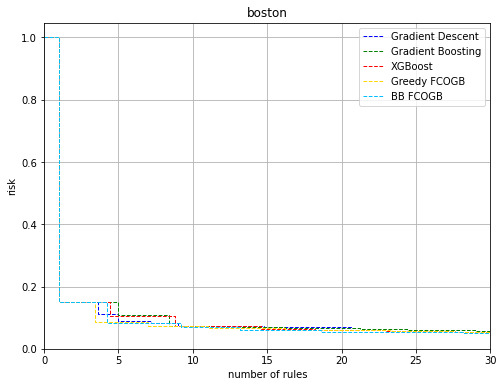

30.46778212179487
mwg_boosting_: avg train risk: 0.014676612720558252 avg test risk 0.015464801672391504 &s: 9.959999999999999
gpe_boosting_: avg train risk: 0.012902558018918518 avg test risk 0.018124665397095247 &s: 14.14
xgb_keep_: avg train risk: 0.012182235825201195 avg test risk 0.01738522970930265 &s: 18.86
orth_fc_Newton-CG: avg train risk: 0.011517029161067702 avg test risk 0.014833321567717073 &s: 13.02
orth_fc_Newton-CG: avg train risk: 0.010671736449924875 avg test risk 0.01623955792014107 &s: 17.48
mwg_boosting__greedy auc: 0.04729645146893962 0.04846110125397444
gpe_boosting__greedy auc: 0.047539800829902265 0.05304957929496202
xgb_keep__exhaustive auc: 0.049383562872883854 0.05304527723388397
orth_fc_Newton-CG_greedy auc: 0.04549363031623992 0.04891599402252829
orth_fc_Newton-CG_exhaustive auc: 0.04655555112633317 0.051103803362634564


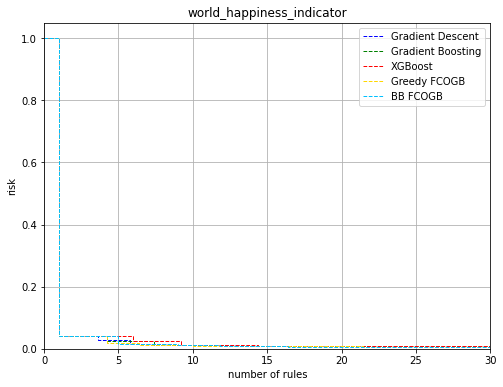

4882.764241803283
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/who_life_expectancy/who_life_expectancy_mwg_boosting__realkd_col_5_rep1.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/who_life_expectancy/who_life_expectancy_mwg_boosting__realkd_col_5_rep2.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/who_life_expectancy/who_life_expectancy_mwg_boosting__realkd_col_5_rep3.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/who_life_expectancy/who_life_expectancy_mwg_boosting__realkd_col_5_rep4.txt
mwg_boosting_: avg train risk: 0.006892024316281775 avg test risk 0.007298997871639279 &s: 9.3
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/who_life_expectancy/who_life_expectancy_gpe_boosting__realkd_col_5_rep1.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/who_life_expectancy/who_life_expectancy_gpe_boosting__realkd_col_5_rep2.txt
gpe boosting  does not 

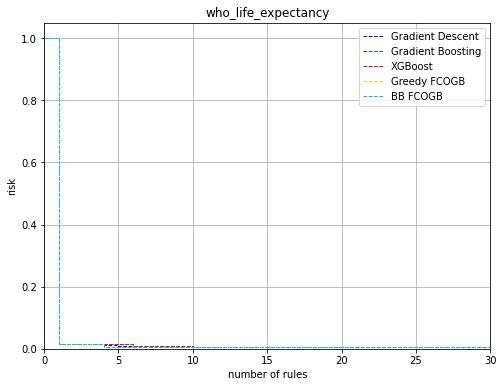

3.5
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/mobile_prices/mobile_prices_mwg_boosting__realkd_col_4_rep1.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/mobile_prices/mobile_prices_mwg_boosting__realkd_col_4_rep2.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/mobile_prices/mobile_prices_mwg_boosting__realkd_col_4_rep3.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/mobile_prices/mobile_prices_mwg_boosting__realkd_col_4_rep4.txt
mwg_boosting_: avg train risk: 0.13195549519448363 avg test risk 0.13678813790149333 &s: 8.2
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/mobile_prices/mobile_prices_gpe_boosting__realkd_col_4_rep1.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/mobile_prices/mobile_prices_gpe_boosting__realkd_col_4_rep2.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/mobile_prices/mobile_prices_gpe_boosting__r

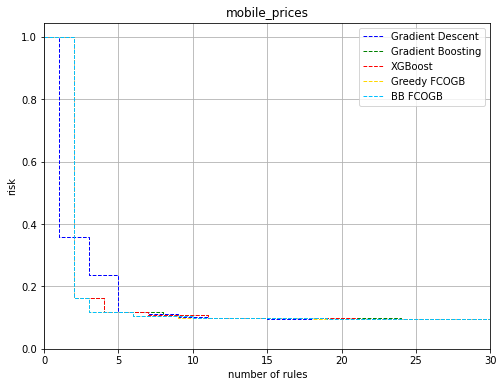

523.7783290690134
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/suicide_rates_cleaned/suicide_rates_cleaned_mwg_boosting__realkd_col_3_rep1.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/suicide_rates_cleaned/suicide_rates_cleaned_mwg_boosting__realkd_col_3_rep2.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/suicide_rates_cleaned/suicide_rates_cleaned_mwg_boosting__realkd_col_3_rep3.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/suicide_rates_cleaned/suicide_rates_cleaned_mwg_boosting__realkd_col_3_rep4.txt
mwg_boosting_: avg train risk: 0.5268062348786469 avg test risk 0.5040625094371218 &s: 6.5
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/suicide_rates_cleaned/suicide_rates_cleaned_gpe_boosting__realkd_col_3_rep1.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/suicide_rates_cleaned/suicide_rates_cleaned_gpe_boosting__realkd_col_3_rep2.txt
gpe

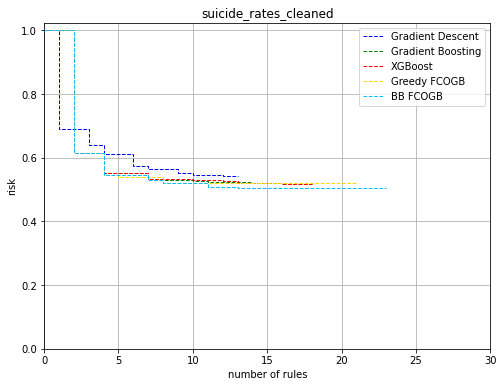

2.70680865164444
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/videogamesales/videogamesales_mwg_boosting__realkd_col_3_rep1.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/videogamesales/videogamesales_mwg_boosting__realkd_col_3_rep2.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/videogamesales/videogamesales_mwg_boosting__realkd_col_3_rep3.txt
mwg boosting  does not exist: 
../experiment_output_20230413_greedy/videogamesales/videogamesales_mwg_boosting__realkd_col_3_rep4.txt
mwg_boosting_: avg train risk: 0.8569628814731582 avg test risk 0.6425265245884715 &s: 6.5
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/videogamesales/videogamesales_gpe_boosting__realkd_col_3_rep1.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/videogamesales/videogamesales_gpe_boosting__realkd_col_3_rep2.txt
gpe boosting  does not exist: 
../experiment_output_20230413_greedy/videogamesales/video

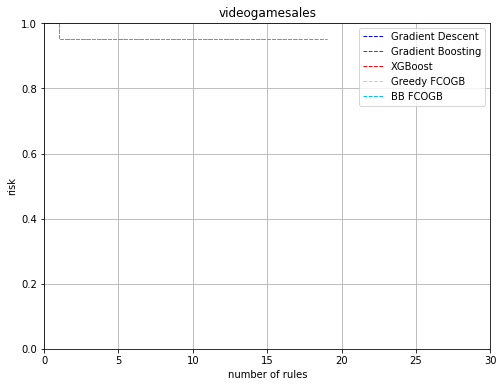

32.41651031894934
mwg_boosting_: avg train risk: 0.014289340576941294 avg test risk 0.014385355453752049 &s: 8.6
gpe_boosting_: avg train risk: 0.014156158730135033 avg test risk 0.014585573943222182 &s: 14.52
xgb_keep_: avg train risk: 0.013788427543302386 avg test risk 0.014558340358069927 &s: 18.240000000000002
orth_fc_Newton-CG: avg train risk: 0.01371624861285085 avg test risk 0.01399951927437286 &s: 11.66
orth_fc_Newton-CG: avg train risk: 0.013485770310557074 avg test risk 0.013977594063927488 &s: 17.380000000000003
mwg_boosting__greedy auc: 0.04813504181581529 0.048242136090861906
gpe_boosting__greedy auc: 0.04868287147979041 0.049065942793453735
xgb_keep__exhaustive auc: 0.04847427504793893 0.04903269008285441
orth_fc_Newton-CG_greedy auc: 0.04776388436849048 0.04806026373654702
orth_fc_Newton-CG_exhaustive auc: 0.048015976396816075 0.04834324484871176


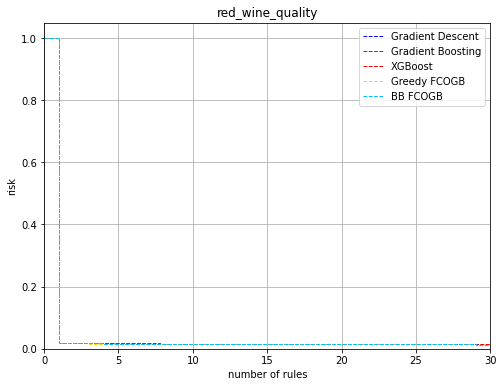

51.62076805721374
mwg_boosting_: avg train risk: 0.11970051493391716 avg test risk 0.13793197201814084 &s: 10.940000000000001
gpe_boosting_: avg train risk: 0.10912758657124877 avg test risk 0.1076052637524874 &s: 12.48
xgb_keep_: avg train risk: 0.5792279329035546 avg test risk 0.6038089517929743 &s: 12.32
orth_fc_Newton-CG: avg train risk: 0.09495757824073339 avg test risk 0.10029966371445179 &s: 11.14
orth_fc_Newton-CG: avg train risk: 0.0966001523760058 avg test risk 0.10448405927300204 &s: 12.58
mwg_boosting__greedy auc: 0.20197669910387034 0.21748106065992873
gpe_boosting__greedy auc: 0.18394989679203755 0.1797782721505967
xgb_keep__exhaustive auc: 0.5787469901545229 0.6029890983420406
orth_fc_Newton-CG_greedy auc: 0.1679662515609387 0.1738278393161831
orth_fc_Newton-CG_exhaustive auc: 0.1779246316626441 0.18535759853303815


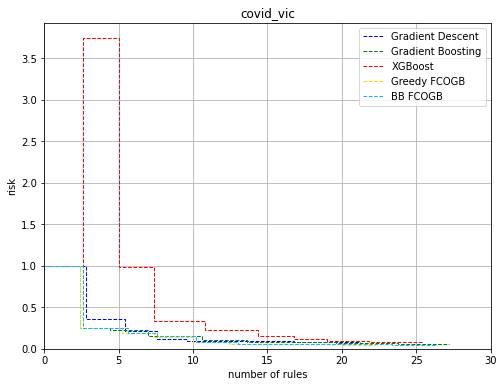

1082.8170359400497
mwg_boosting_: avg train risk: 0.32220917338507593 avg test risk 0.40720765711504353 &s: 11.66
gpe_boosting_: avg train risk: 0.30149508476840425 avg test risk 0.41045284987357267 &s: 16.86
xgb_keep_: avg train risk: 3.7258504655457267 avg test risk 5.346290569252612 &s: 15.559999999999999
orth_fc_Newton-CG: avg train risk: 0.28897409413435826 avg test risk 0.40267995893646635 &s: 16.080000000000002
orth_fc_Newton-CG: avg train risk: 0.28738013692274755 avg test risk 0.39961205763186364 &s: 16.56
mwg_boosting__greedy auc: 0.38608342619096264 0.4775994281136949
gpe_boosting__greedy auc: 0.4345367206531285 0.539512283793684
xgb_keep__exhaustive auc: 4.265709294465633 5.902597438168735
orth_fc_Newton-CG_greedy auc: 0.42154066287557407 0.5282148869684666
orth_fc_Newton-CG_exhaustive auc: 0.4084889166491917 0.5148708392340956


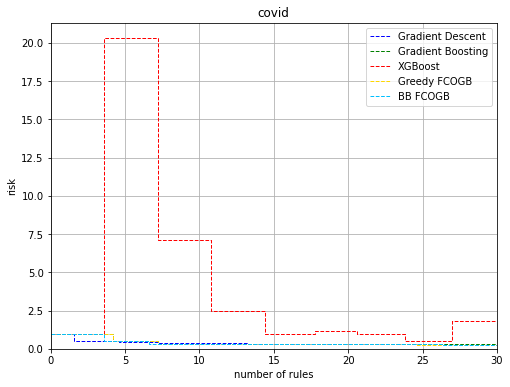

1076.416963882381
mwg_boosting_: avg train risk: 0.3528924659577613 avg test risk 0.40034821116847163 &s: 11.620000000000001
gpe_boosting_: avg train risk: 0.25787327807913024 avg test risk 0.3559467478083891 &s: 19.0
xgb_keep_: avg train risk: 0.253322783867886 avg test risk 0.3512709554100578 &s: 18.06
orth_fc_Newton-CG: avg train risk: 0.2510349442536871 avg test risk 0.358946505797683 &s: 17.48
orth_fc_Newton-CG: avg train risk: 0.23370328043230684 avg test risk 0.3806556783029691 &s: 19.78
mwg_boosting__greedy auc: 0.4369577013274073 0.48485172464770476
gpe_boosting__greedy auc: 0.4038107619802499 0.4695267378268336
xgb_keep__exhaustive auc: 0.4115460366678987 0.4793154289287349
orth_fc_Newton-CG_greedy auc: 0.3974231945253591 0.4671161932462585
orth_fc_Newton-CG_exhaustive auc: 0.40096722016608716 0.5048003762755314


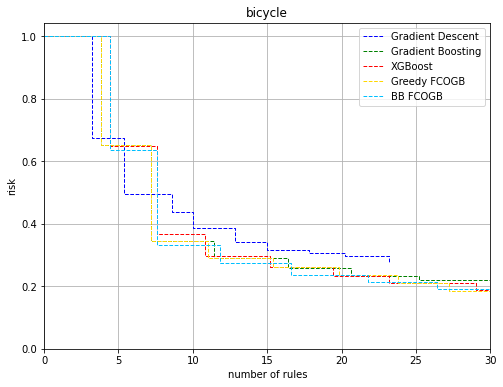

12.342277392898044
mwg_boosting_: avg train risk: 0.15436278479226245 avg test risk 0.18870679297929205 &s: 12.36
gpe_boosting_: avg train risk: 0.13747580942385684 avg test risk 0.2457857379503951 &s: 14.62
xgb_keep_: avg train risk: 125.18093464422086 avg test risk 156.62087071571315 &s: 14.580000000000002
orth_fc_Newton-CG: avg train risk: 0.09630772549813249 avg test risk 0.375347368923606 &s: 14.5
orth_fc_Newton-CG: avg train risk: 0.10340334832907246 avg test risk 0.2654296012237273 &s: 16.66
mwg_boosting__greedy auc: 0.21201659725312144 0.2487776692726501
gpe_boosting__greedy auc: 0.2441537921559113 0.35277253166576894
xgb_keep__exhaustive auc: 145.24426792340492 181.60815943421807
orth_fc_Newton-CG_greedy auc: 0.20252801941242782 0.4445337503552038
orth_fc_Newton-CG_exhaustive auc: 0.22272942708914958 0.33759924885634696


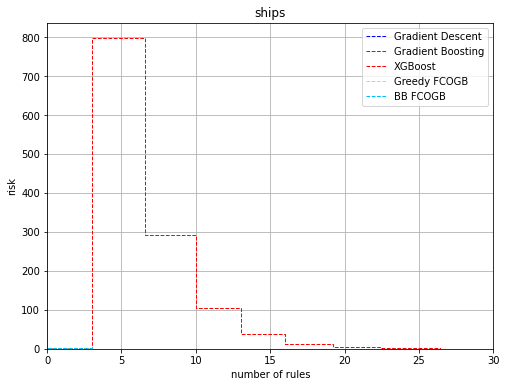

7.500299349437478
mwg_boosting_: avg train risk: 0.12143312557641842 avg test risk 0.11155542336764232 &s: 10.16
gpe_boosting_: avg train risk: 0.09637852421613527 avg test risk 0.17924217545230076 &s: 12.7
xgb_keep_: avg train risk: 0.25377624388085607 avg test risk 0.3336319415023762 &s: 10.879999999999999
orth_fc_Newton-CG: avg train risk: 0.08740321847899347 avg test risk 0.17224338776534037 &s: 11.9
orth_fc_Newton-CG: avg train risk: 0.08412185295085385 avg test risk 0.15632487601244224 &s: 12.059999999999999
mwg_boosting__greedy auc: 0.17146312479815518 0.17014856316554122
gpe_boosting__greedy auc: 0.15890041664293517 0.24490372336761157
xgb_keep__exhaustive auc: 0.25585864393364877 0.3404958573199652
orth_fc_Newton-CG_greedy auc: 0.1449650796575375 0.23321457549557684
orth_fc_Newton-CG_exhaustive auc: 0.1421297664830711 0.21600032414869952


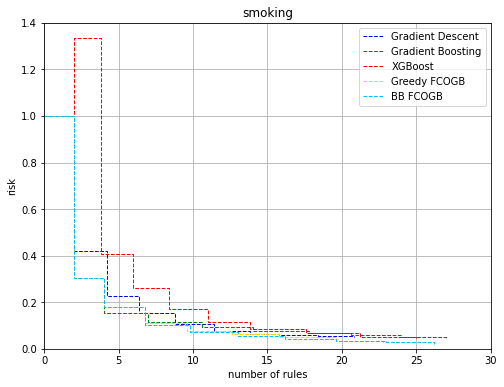

done


In [27]:
datasets = ['titanic','tic-tac-toe','iris','breast_cancer','load_wine',
            'IBM_HR', 'telco_churn', 'GenderRecognition',
            'banknote', 'liver', 'magic', 'adult', 'digits5',
            'insurance','make_friedman1',
            'make_friedman2','make_friedman3','wage', 'Demographics','gdp','used_cars','load_diabetes',
            'boston','world_happiness_indicator', 'who_life_expectancy', 'mobile_prices', 'suicide_rates_cleaned','videogamesales',
             'red_wine_quality',
            'covid_vic','covid',
            'bicycle','ships','smoking']

values = [
    'mwg_boosting__greedy',
    'gpe_boosting__greedy', 
    'xgb_keep__exhaustive', 
    'orth_fc_Newton-CG_greedy',
    'orth_fc_Newton-CG_exhaustive'
]
print(len(datasets))
cols = [10, 10, 10, 5, 6, 
        3, 4, 3, 10, 10, 5, 5, 3,
        10, 4, 10, 10, 10,
       2, 20, 10, 5, 4, 10, 5, 4, 3, 3, 5,
        10, 10, 10, 10, 10]
max_components = [30] * len(datasets)
max_components[14]=25
max_components[15]=20
f = open("../analysis_results/compare_test_greedy.csv", 'w')
f2 = open("../analysis_results/compare_train_greedy.csv", 'w')
f.write('dataset'+(','+','.join(values))*4+'\n')
for i in range(len(datasets)):
#     try:
        max_risk = get_max_risk(datasets[i])
        train, test, ands, aucs_tr, aucs_te = compare_risks_greedy(datasets[i], col=cols[i], max_length=max_components[i])
#         gpe_orth_test = largest_gaps(test, ands, 'gpe_boosting__greedy', 'orth_fc_Newton-CG')
#         xgb_orth_test = largest_gaps(test, ands, 'xgb_keep_', 'orth_fc_Newton-CG')
#         orth_gpe_test = largest_gaps(test, ands, 'orth_fc_Newton-CG', 'gpe_boosting_')
#         orth_xgb_test = largest_gaps(test, ands, 'orth_fc_Newton-CG', 'xgb_keep_')
#         orth_mwg_test = largest_gaps(test, ands, 'orth_fc_Newton-CG', 'mwg_boosting_')
#         mwg_orth_test = largest_gaps(test, ands, 'mwg_boosting_', 'orth_fc_Newton-CG')
#         gpe_orth_train = largest_gaps(train, ands, 'gpe_boosting_', 'orth_fc_Newton-CG')
#         xgb_orth_train = largest_gaps(train, ands, 'xgb_keep_', 'orth_fc_Newton-CG')
#         orth_gpe_train = largest_gaps(train, ands, 'orth_fc_Newton-CG', 'gpe_boosting_')
#         orth_xgb_train = largest_gaps(train, ands, 'orth_fc_Newton-CG', 'xgb_keep_')
#         orth_mwg_train = largest_gaps(train, ands, 'orth_fc_Newton-CG', 'mwg_boosting_')
#         mwg_orth_train = largest_gaps(train, ands, 'mwg_boosting_', 'orth_fc_Newton-CG')
        
        f.write(datasets[i] + ',')
        for value in values:
            f.write(str(max(ands[value]))+',')
        for value in values:
            f.write(str(aucs_te[value])+',')
#         f.write(str(mwg_orth_test[0])+','+str(mwg_orth_test[1])+','+str(mwg_orth_test[2])+','+str(mwg_orth_test[3])+',')
#         f.write(str(gpe_orth_test[0])+','+str(gpe_orth_test[1])+','+str(gpe_orth_test[2])+','+str(gpe_orth_test[3])+',')
#         f.write(str(xgb_orth_test[0])+','+str(xgb_orth_test[1])+','+str(xgb_orth_test[2])+','+str(xgb_orth_test[3])+',')
#         f.write(str(orth_mwg_test[0])+','+str(orth_mwg_test[1])+','+str(orth_mwg_test[2])+','+str(orth_mwg_test[3])+',')
#         f.write(str(orth_gpe_test[0])+','+str(orth_gpe_test[1])+','+str(orth_gpe_test[2])+','+str(orth_gpe_test[3])+',')
#         f.write(str(orth_xgb_test[0])+','+str(orth_xgb_test[1])+','+str(orth_xgb_test[2])+','+str(orth_xgb_test[3])+',')
        f.write('\n')
        
        f2.write(datasets[i] + ',')
        for value in values:
            f2.write(str(max(ands[value]))+',')
        for value in values:
            f2.write(str(aucs_tr[value])+',')
#         f2.write(str(mwg_orth_train[0])+','+str(mwg_orth_train[1])+','+str(mwg_orth_train[2])+','+str(mwg_orth_train[3])+',')
#         f2.write(str(gpe_orth_train[0])+','+str(gpe_orth_train[1])+','+str(gpe_orth_train[2])+','+str(gpe_orth_train[3])+',')
#         f2.write(str(xgb_orth_train[0])+','+str(xgb_orth_train[1])+','+str(xgb_orth_train[2])+','+str(xgb_orth_train[3])+',')
#         f2.write(str(orth_mwg_train[0])+','+str(orth_mwg_train[1])+','+str(orth_mwg_train[2])+','+str(orth_mwg_train[3])+',')
#         f2.write(str(orth_gpe_train[0])+','+str(orth_gpe_train[1])+','+str(orth_gpe_train[2])+','+str(orth_gpe_train[3])+',')
#         f2.write(str(orth_xgb_train[0])+','+str(orth_xgb_train[1])+','+str(orth_xgb_train[2])+','+str(orth_xgb_train[3])+',')
        f2.write('\n')

f.close()
f2.close()
print('done')